In [1]:
.libPaths( c( .libPaths(), "/home/amazigh.mokhtari/NeuroDev_ADD/R/r_3.6.0/") )
options(repr.plot.width=18, repr.plot.height=24)


In [2]:
library (dplyr)
library (RGCCA)
###Parallelization libraries 
library(tictoc)
library(ccaPP)
library(ROCR)
library(pbmcapply)
library(ordinal)
library(foreach)
library(parglm)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: parallel

Loading required package: pcaPP

Loading required package: robustbase


Attaching package: ‘ordinal’


The following object is masked from ‘package:dplyr’:

    slice




In [3]:
####################
## Load functions ##
####################
fun_dir = dirname(getwd())
# RGCCA
devtools::load_all(file.path(dirname(getwd()) , "/RGCCA_factory/RGCCA/."))
source(file.path(dirname(getwd()) , "/additional_functions/compute_SGCCA_multi-Copy1.R"))
source(file.path(dirname(getwd()) , "/additional_functions/scale_test.R"))

ℹ Loading RGCCA

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [4]:
omics = readRDS ("00_Data/MDD_Male_DNAm_No_preserv.RDS")
num.factors = 10

In [8]:
library(tidyverse)

RGCCAtest = function (file , type = type , scale_block = TRUE ,  params.RGCCA , ... ) {
    
    ## RGCCA_Multi_unsupervised_DNAm_Filtered.
    A                        = params.RGCCA$A
    C                        = params.RGCCA$C
    c1                       = params.RGCCA$c1
    ncomp                    = params.RGCCA$ncomp


    SGCCA_results_summary    = read.table(file = file , sep ="\t")
    
    if (type != "MDD_Hamilton"){
        SGCCA_results_summary$V2        = paste0 ("CV_fold_" , SGCCA_results_summary$V2)
        SGCCA_results_summary           = SGCCA_results_summary %>% spread (V2,V3) %>% column_to_rownames(var="V1")
        parameters_row                  = rownames(SGCCA_results_summary)
        #Define best parameters
        best_parameters                 = (parameters_row)[which.max(apply(SGCCA_results_summary, 1, median))]
        best_parameters                 = as.numeric(strsplit(x = best_parameters, split = ",")[[1]])
    }else {
        colnames(SGCCA_results_summary) = c("params" , "CV_Fold" , "RMSE" , "COR" , "Rsquare")
        SGCCA_results_summary$CV_Fold   = paste0 ("CV_fold_" , SGCCA_results_summary$CV_Fold)
        SGCCA_results_summary           = SGCCA_results_summary %>% 
                                            dplyr::select (params,CV_Fold,RMSE) %>% 
                                            spread (CV_Fold,RMSE) %>% 
                                            column_to_rownames(var="params")
        parameters_row                  = rownames(SGCCA_results_summary)
        #Define best parameters
        best_parameters                 = (parameters_row)[which.max(apply(SGCCA_results_summary, 1, mean))]
        best_parameters                 = as.numeric(strsplit(x = best_parameters, split = ",")[[1]])
    }
    ###############
    ## RUN SGCCA ##
    ###############
    print ("########### Best Parameters ################ \n ")
    print (best_parameters)
    
    blocks = if (type == "MDD_Unsupervised") { blocks = A[1:3]} else { blocks = A}  
    
    result.sgcca = rgcca(blocks  = blocks, 
                     connection  = C, 
                     ncomp       = ncomp,
                     scheme      = scheme, 
                     init        = init,
                     scale       = scale,
                     scale_block = scale_block,
                     verbose     = TRUE, 
                     type        = "sgcca", 
                     sparsity    = best_parameters)
    
    ## Save file in RDS 
    saveRDS (result.sgcca , file = gsub(".txt$", "_result.sgcca.RDS", file))
    
    return(result.sgcca)

}



── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ordinal::slice()    masks dplyr::slice()
✖ purrr::when()       masks foreach::when()



In [7]:
saveRDS (result.sgcca , file = "02_Results/01_MDD_Male_DNAm_No_preserv/06_factorizations_SGCCA_dry.RDS" )

Computation of the RGCCA block components based on the centroid scheme 
Shrinkage intensity paramaters are chosen manually 
Computation of the RGCCA block components #1 is under 
                 progress...
 Iter:    1  Fit: 1.16977340  Dif:  0.05910409 
 Iter:    2  Fit: 1.17011996  Dif:  0.00034656 
 Iter:    3  Fit: 1.17013599  Dif:  0.00001603 
 Iter:    4  Fit: 1.17013706  Dif:  0.00000107 
 Iter:    5  Fit: 1.17013716  Dif:  0.00000010 
 Iter:    6  Fit: 1.17013717  Dif:  0.00000001 
 Iter:    7  Fit: 1.17013717  Dif:  0.00000000 
The RGCCA algorithm converged to a stationary point after 6 iterations 
Computation of the RGCCA block components #2 is under 
                 progress...
 Iter:    1  Fit: 0.49683237  Dif:  0.25747617 
 Iter:    2  Fit: 0.60220448  Dif:  0.10537211 
 Iter:    3  Fit: 0.63967216  Dif:  0.03746768 
 Iter:    4  Fit: 0.65000135  Dif:  0.01032919 
 Iter:    5  Fit: 0.65263196  Dif:  0.00263061 
 Iter:    6  Fit: 0.65330019  Dif:  0.00066823 
 Iter:    7 

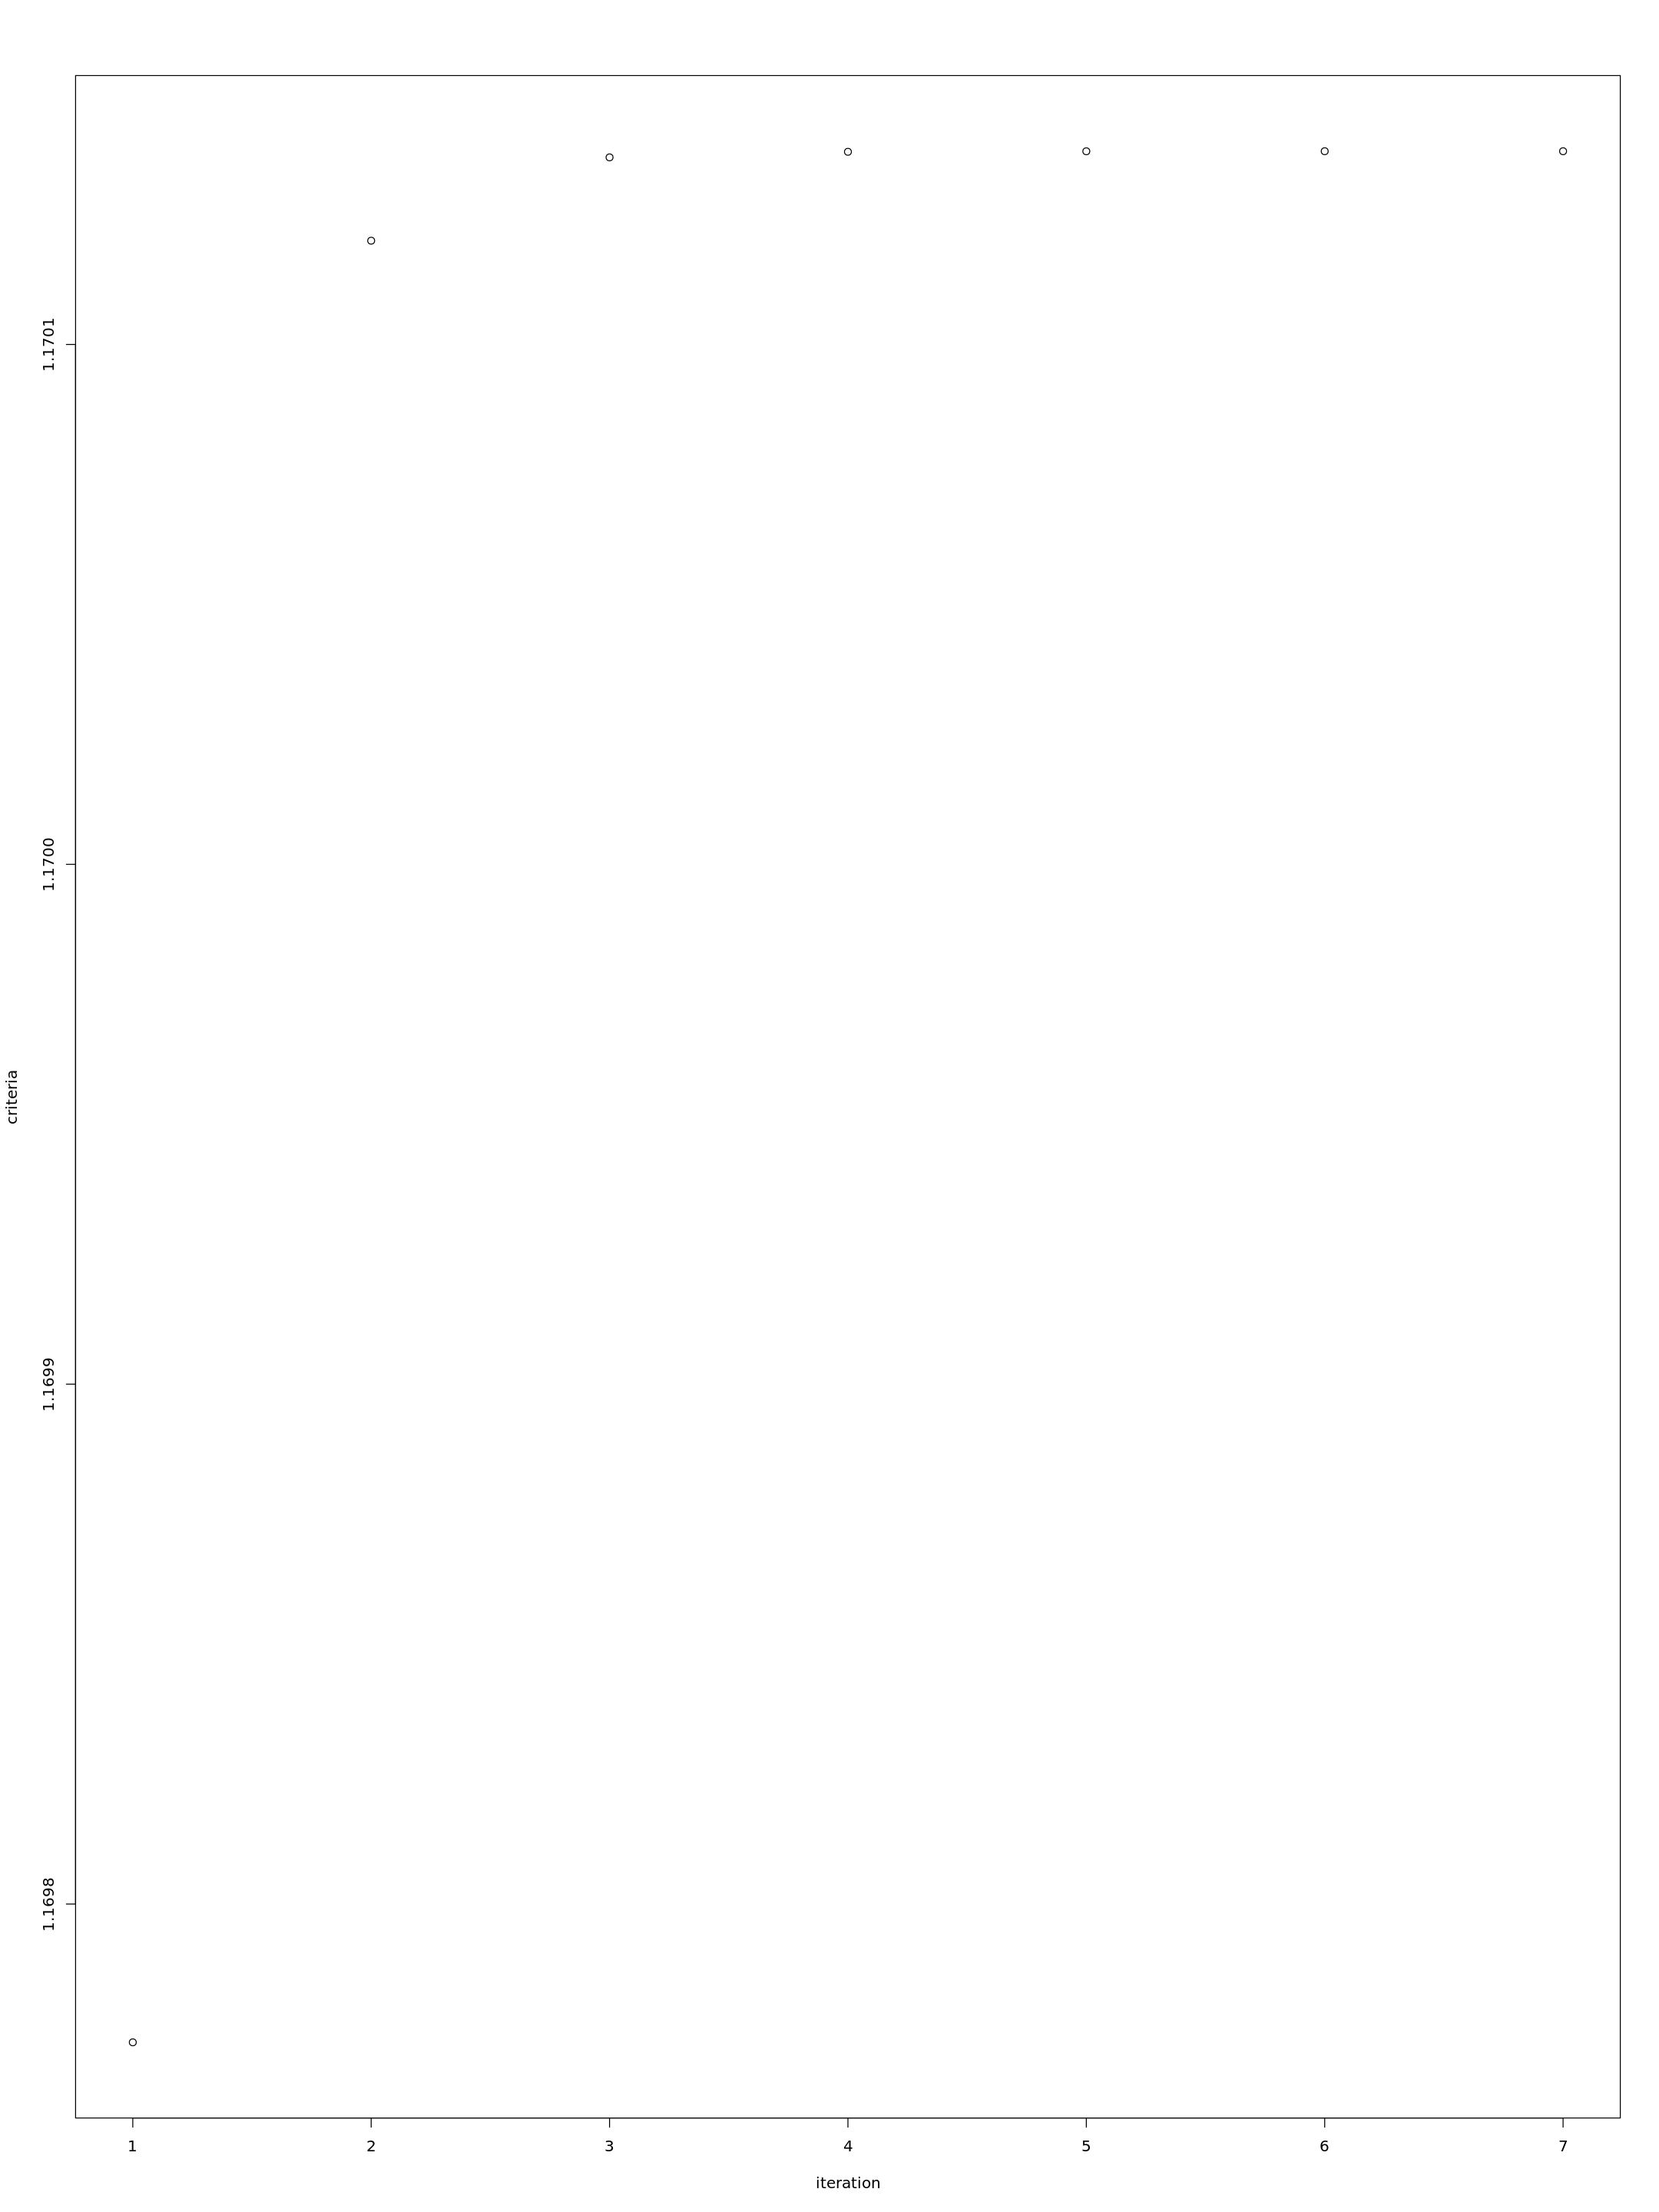

Computation of the RGCCA block components #3 is under 
                 progress...
 Iter:    1  Fit: 0.36184455  Dif:  0.23414976 
 Iter:    2  Fit: 0.39355265  Dif:  0.03170810 
 Iter:    3  Fit: 0.41585309  Dif:  0.02230044 
 Iter:    4  Fit: 0.43445692  Dif:  0.01860384 
 Iter:    5  Fit: 0.44733577  Dif:  0.01287884 
 Iter:    6  Fit: 0.45485887  Dif:  0.00752311 
 Iter:    7  Fit: 0.45883348  Dif:  0.00397461 
 Iter:    8  Fit: 0.46084332  Dif:  0.00200984 
 Iter:    9  Fit: 0.46184907  Dif:  0.00100574 
 Iter:   10  Fit: 0.46235509  Dif:  0.00050602 
 Iter:   11  Fit: 0.46261262  Dif:  0.00025753 
 Iter:   12  Fit: 0.46274534  Dif:  0.00013273 
 Iter:   13  Fit: 0.46281456  Dif:  0.00006921 
 Iter:   14  Fit: 0.46285102  Dif:  0.00003646 
 Iter:   15  Fit: 0.46287038  Dif:  0.00001936 
 Iter:   16  Fit: 0.46288073  Dif:  0.00001035 
 Iter:   17  Fit: 0.46288629  Dif:  0.00000556 
 Iter:   18  Fit: 0.46288930  Dif:  0.00000300 
 Iter:   19  Fit: 0.46289092  Dif:  0.00000163 
 Ite

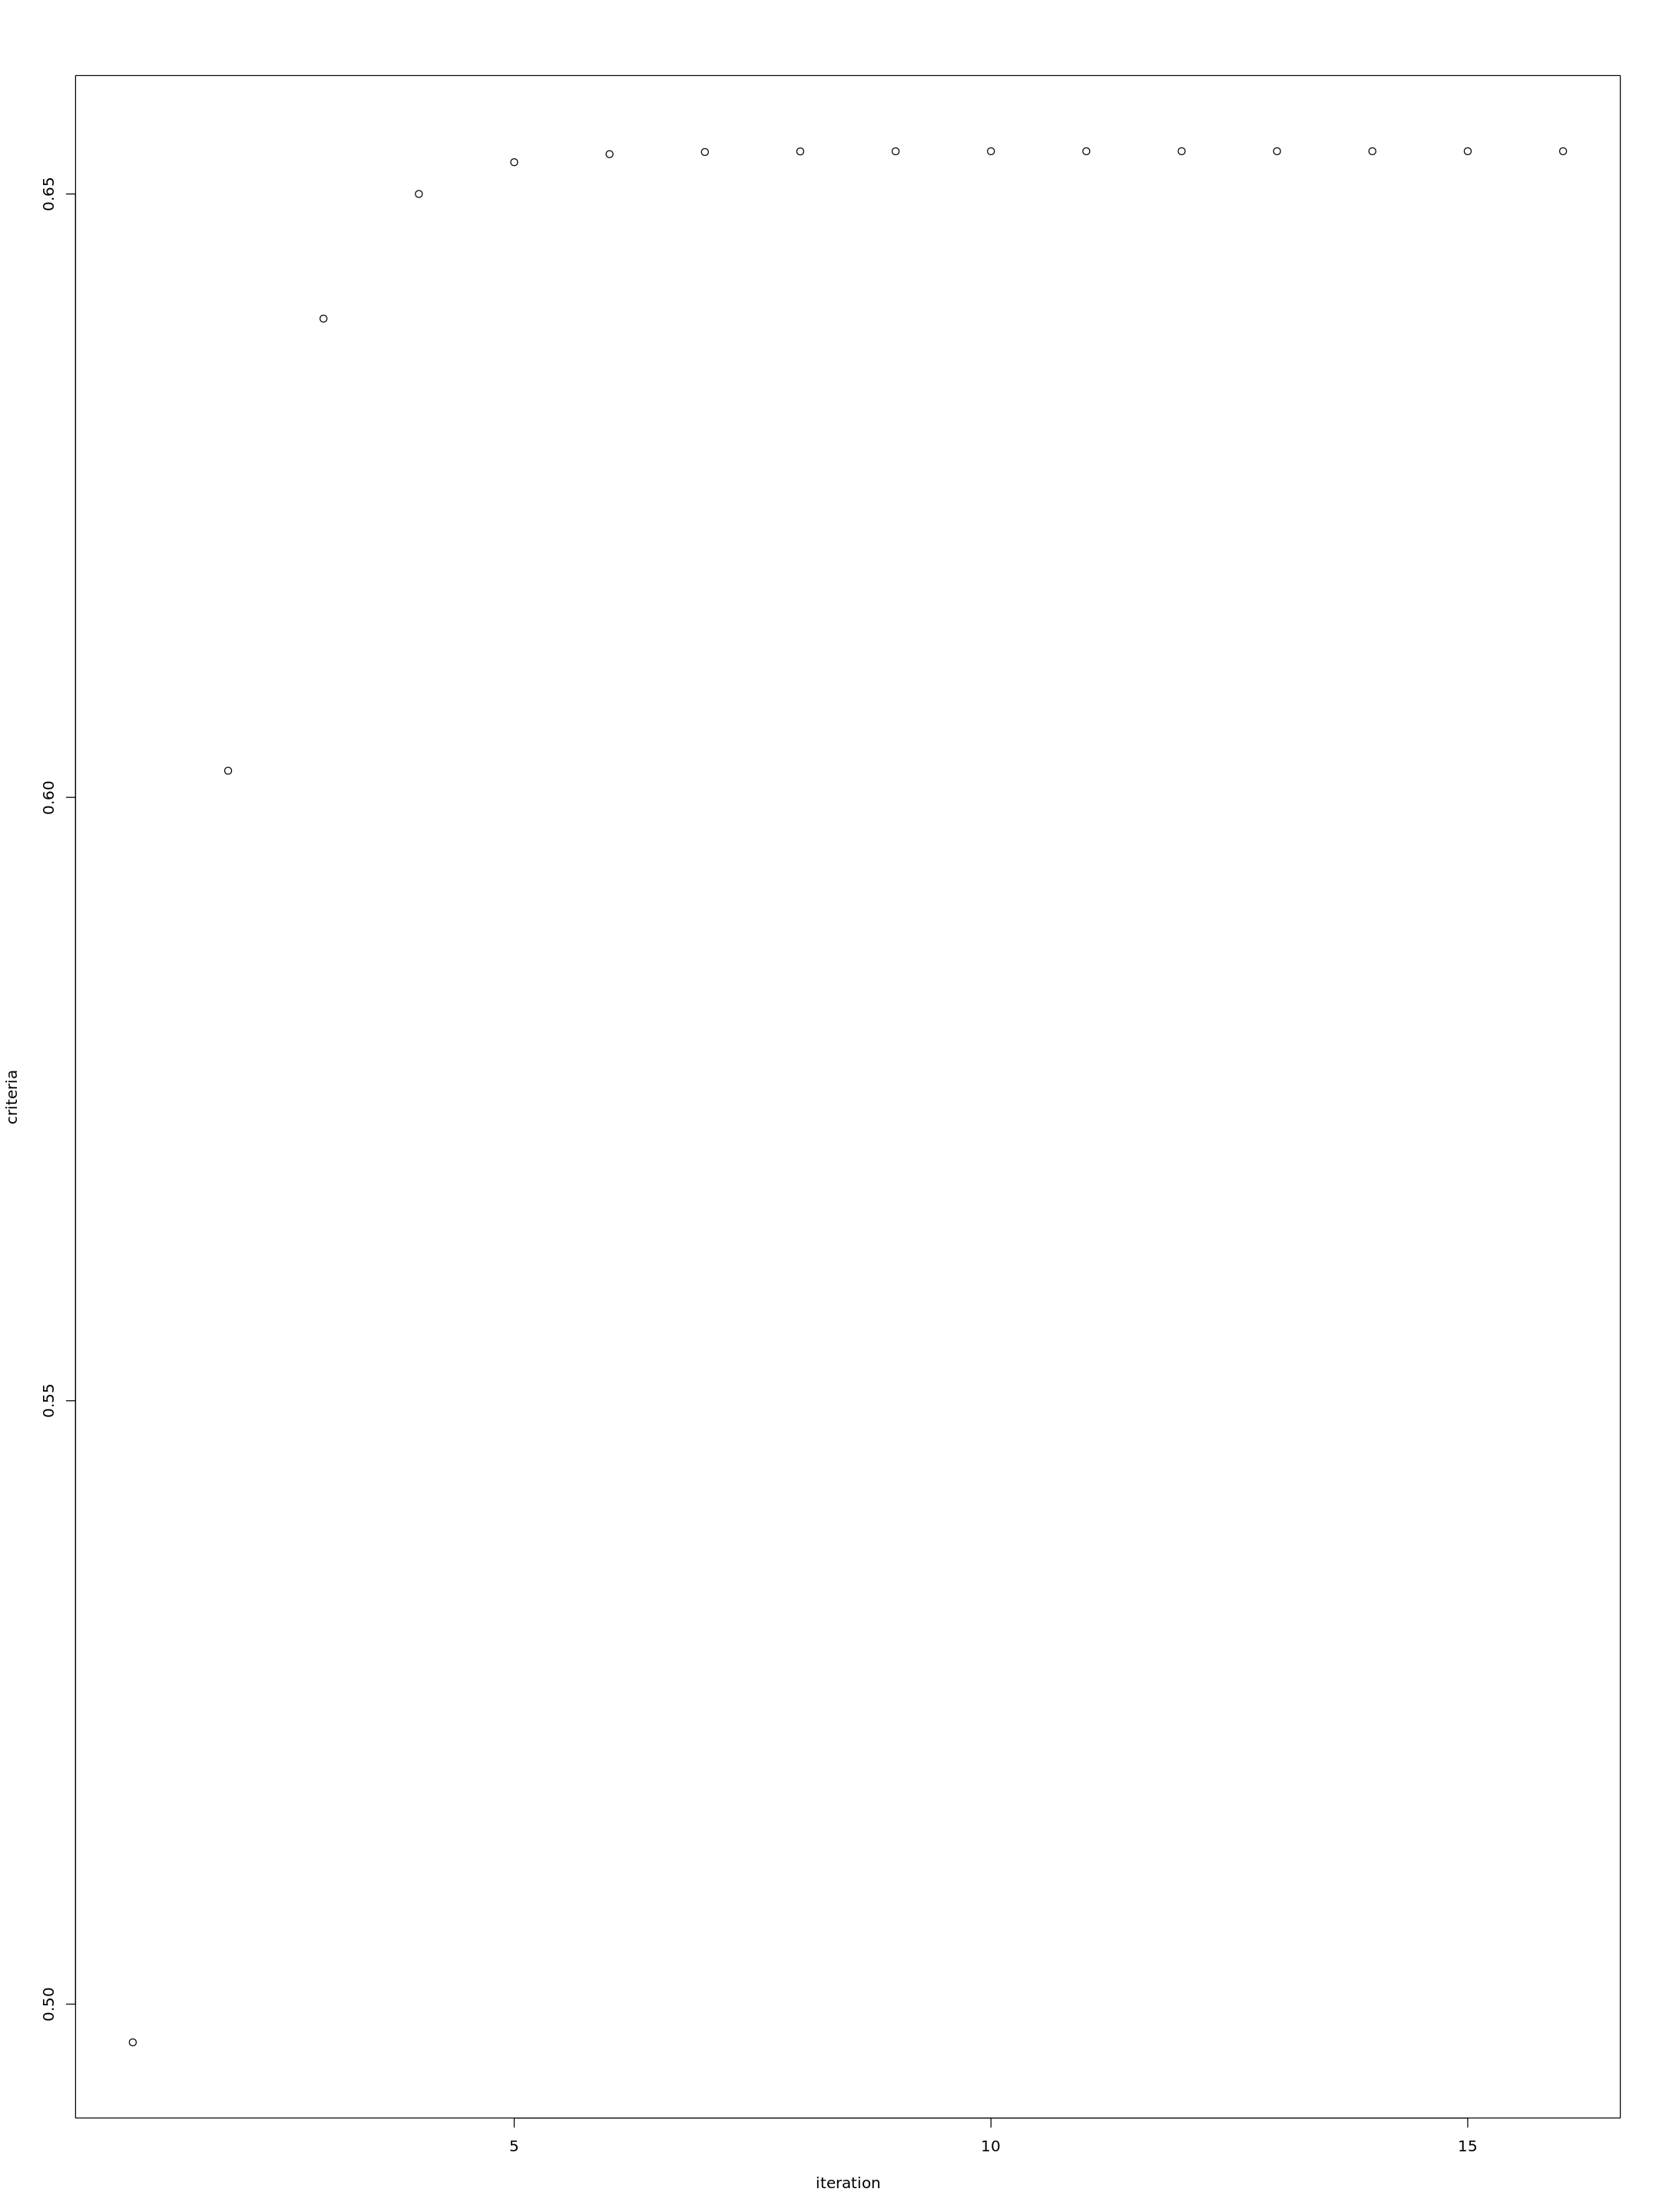

Computation of the RGCCA block components #4 is under 
                 progress...
 Iter:    1  Fit: 0.35200457  Dif:  0.18847941 
 Iter:    2  Fit: 0.36746397  Dif:  0.01545939 
 Iter:    3  Fit: 0.37030466  Dif:  0.00284069 
 Iter:    4  Fit: 0.37102597  Dif:  0.00072131 
 Iter:    5  Fit: 0.37126135  Dif:  0.00023538 
 Iter:    6  Fit: 0.37136634  Dif:  0.00010500 
 Iter:    7  Fit: 0.37142752  Dif:  0.00006118 
 Iter:    8  Fit: 0.37146865  Dif:  0.00004113 
 Iter:    9  Fit: 0.37149789  Dif:  0.00002924 
 Iter:   10  Fit: 0.37151903  Dif:  0.00002114 
 Iter:   11  Fit: 0.37153438  Dif:  0.00001534 
 Iter:   12  Fit: 0.37154550  Dif:  0.00001112 
 Iter:   13  Fit: 0.37155355  Dif:  0.00000804 
 Iter:   14  Fit: 0.37155935  Dif:  0.00000580 
 Iter:   15  Fit: 0.37156352  Dif:  0.00000417 
 Iter:   16  Fit: 0.37156652  Dif:  0.00000300 
 Iter:   17  Fit: 0.37156867  Dif:  0.00000215 
 Iter:   18  Fit: 0.37157020  Dif:  0.00000154 
 Iter:   19  Fit: 0.37157130  Dif:  0.00000110 
 Ite

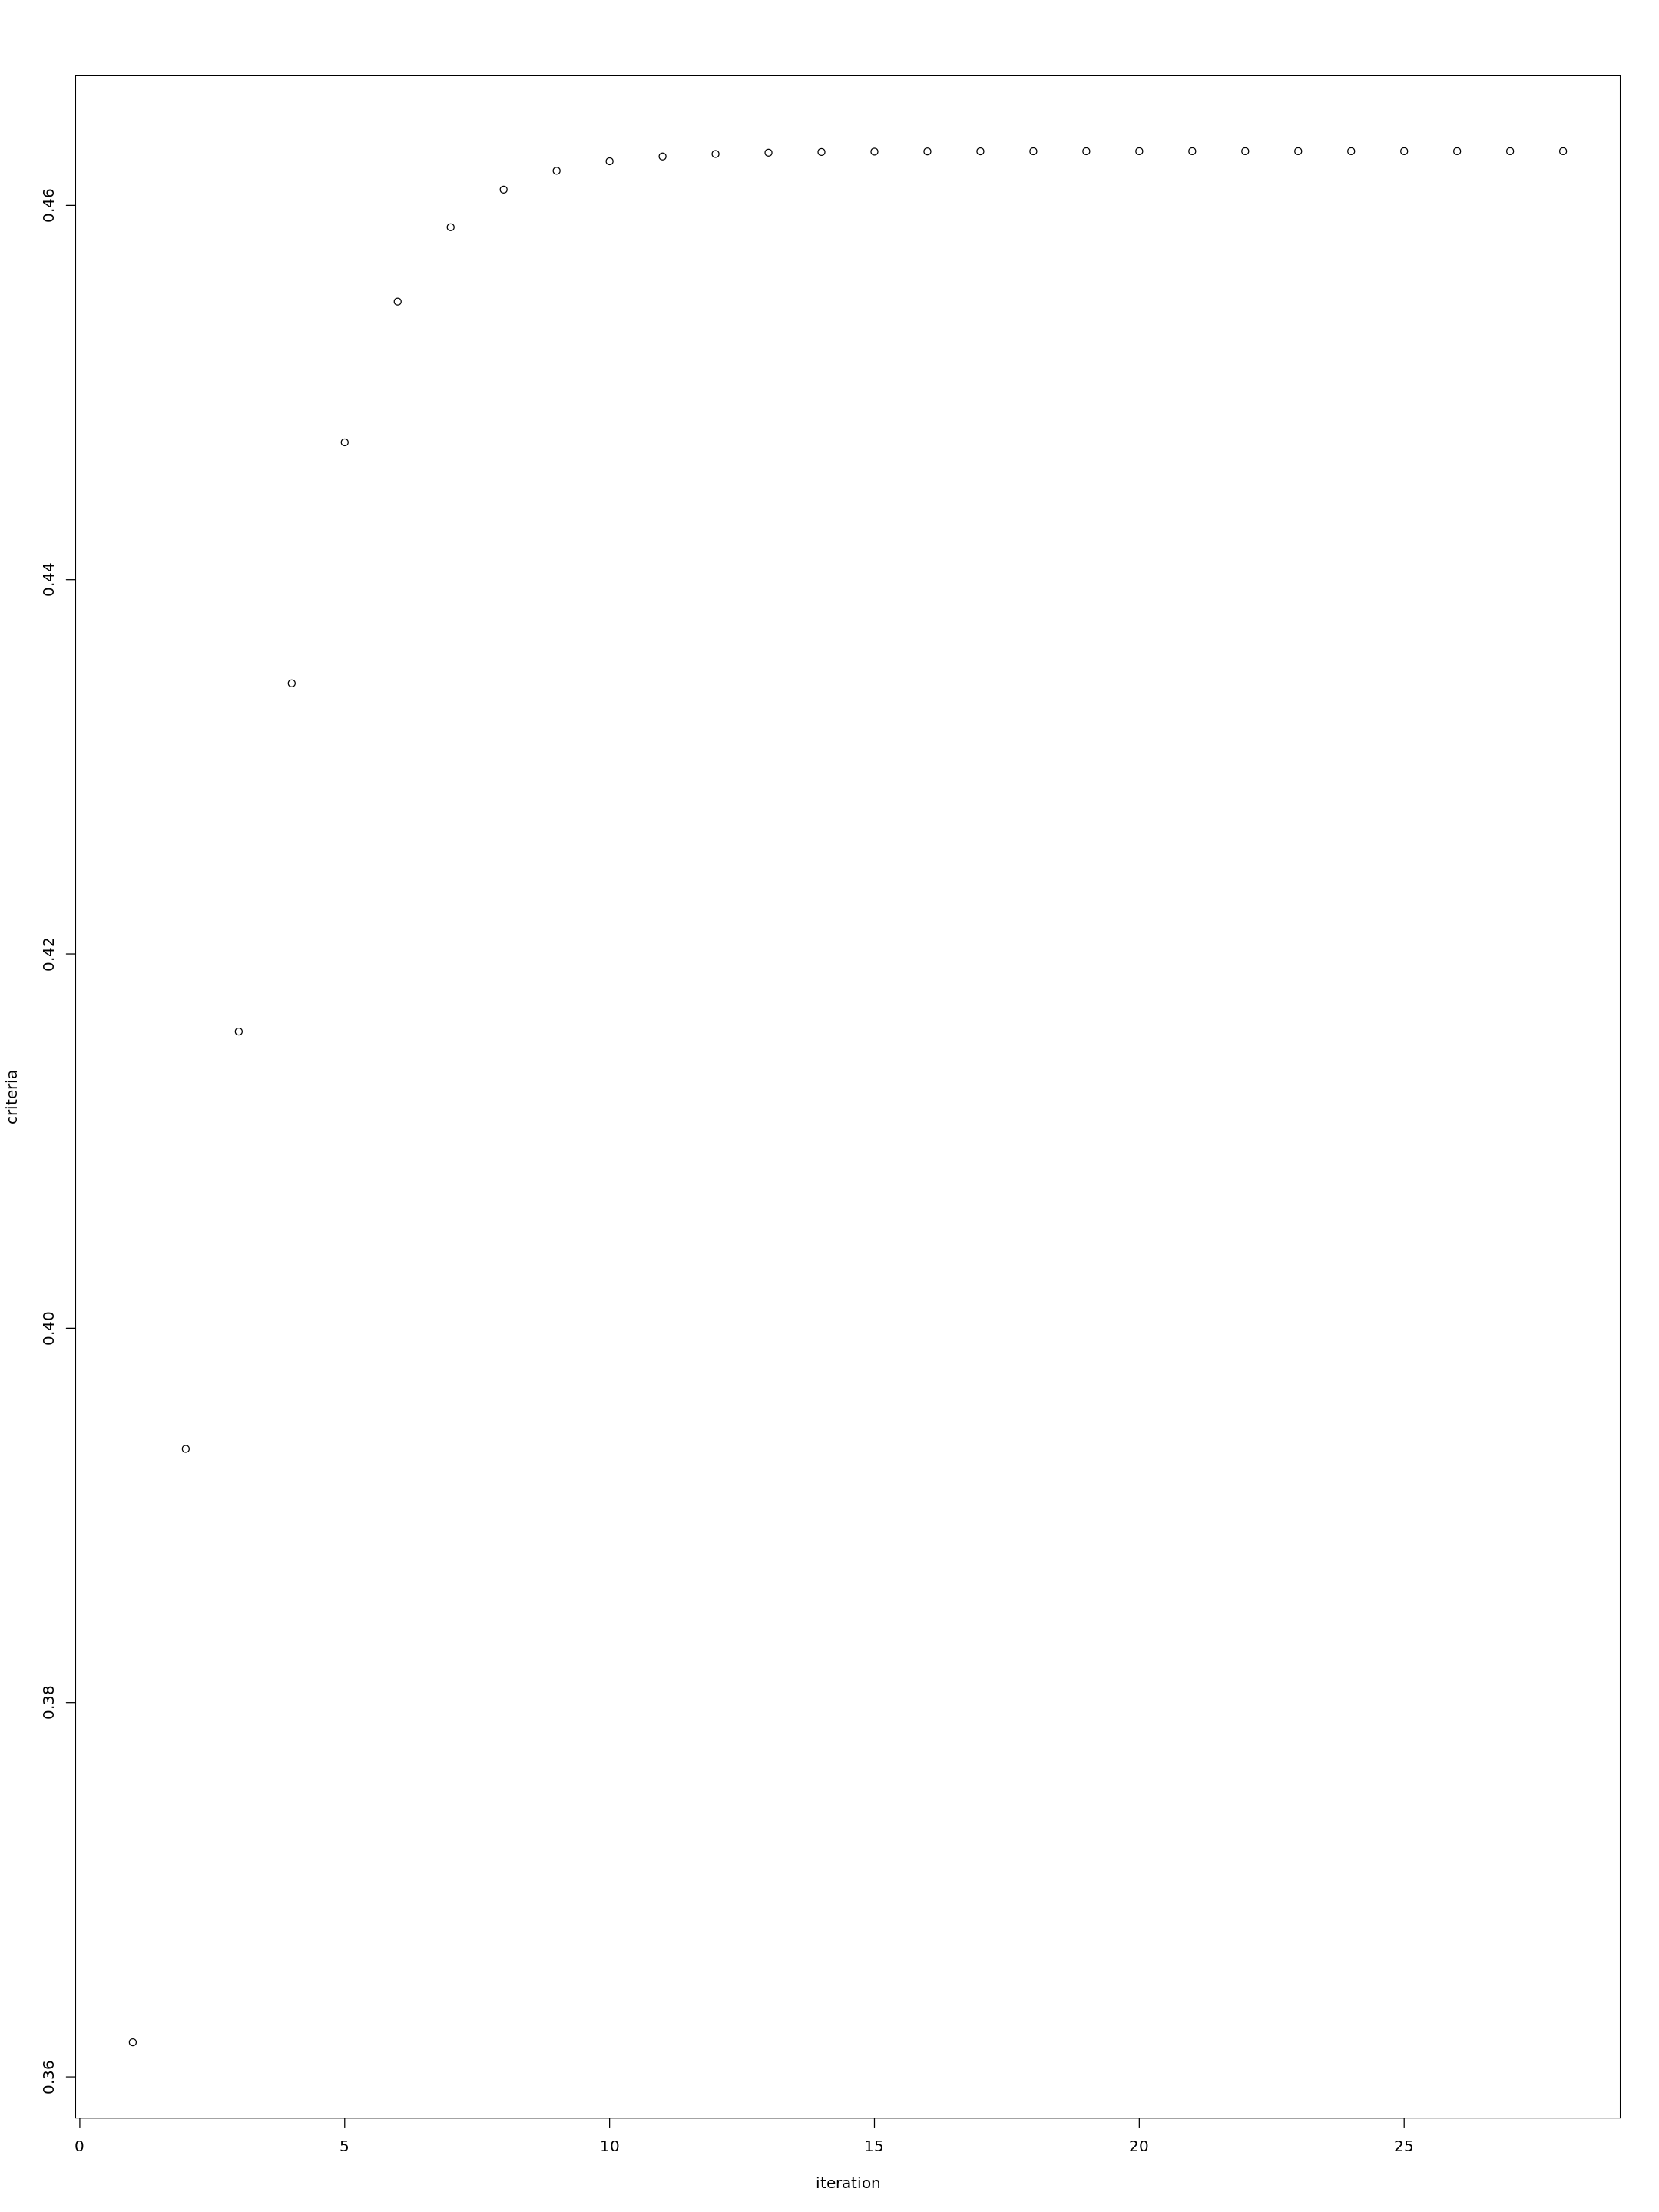

Computation of the RGCCA block components #5 is under 
                 progress...
 Iter:    1  Fit: 0.27402931  Dif:  0.18829934 
 Iter:    2  Fit: 0.29169376  Dif:  0.01766445 
 Iter:    3  Fit: 0.29758674  Dif:  0.00589298 
 Iter:    4  Fit: 0.30029540  Dif:  0.00270866 
 Iter:    5  Fit: 0.30173600  Dif:  0.00144060 
 Iter:    6  Fit: 0.30255005  Dif:  0.00081405 
 Iter:    7  Fit: 0.30302638  Dif:  0.00047633 
 Iter:    8  Fit: 0.30331483  Dif:  0.00028845 
 Iter:    9  Fit: 0.30349794  Dif:  0.00018311 
 Iter:   10  Fit: 0.30362289  Dif:  0.00012494 
 Iter:   11  Fit: 0.30371760  Dif:  0.00009472 
 Iter:   12  Fit: 0.30379946  Dif:  0.00008185 
 Iter:   13  Fit: 0.30387999  Dif:  0.00008054 
 Iter:   14  Fit: 0.30396763  Dif:  0.00008764 
 Iter:   15  Fit: 0.30406921  Dif:  0.00010158 
 Iter:   16  Fit: 0.30419087  Dif:  0.00012165 
 Iter:   17  Fit: 0.30433851  Dif:  0.00014764 
 Iter:   18  Fit: 0.30451807  Dif:  0.00017955 
 Iter:   19  Fit: 0.30473548  Dif:  0.00021742 
 Ite

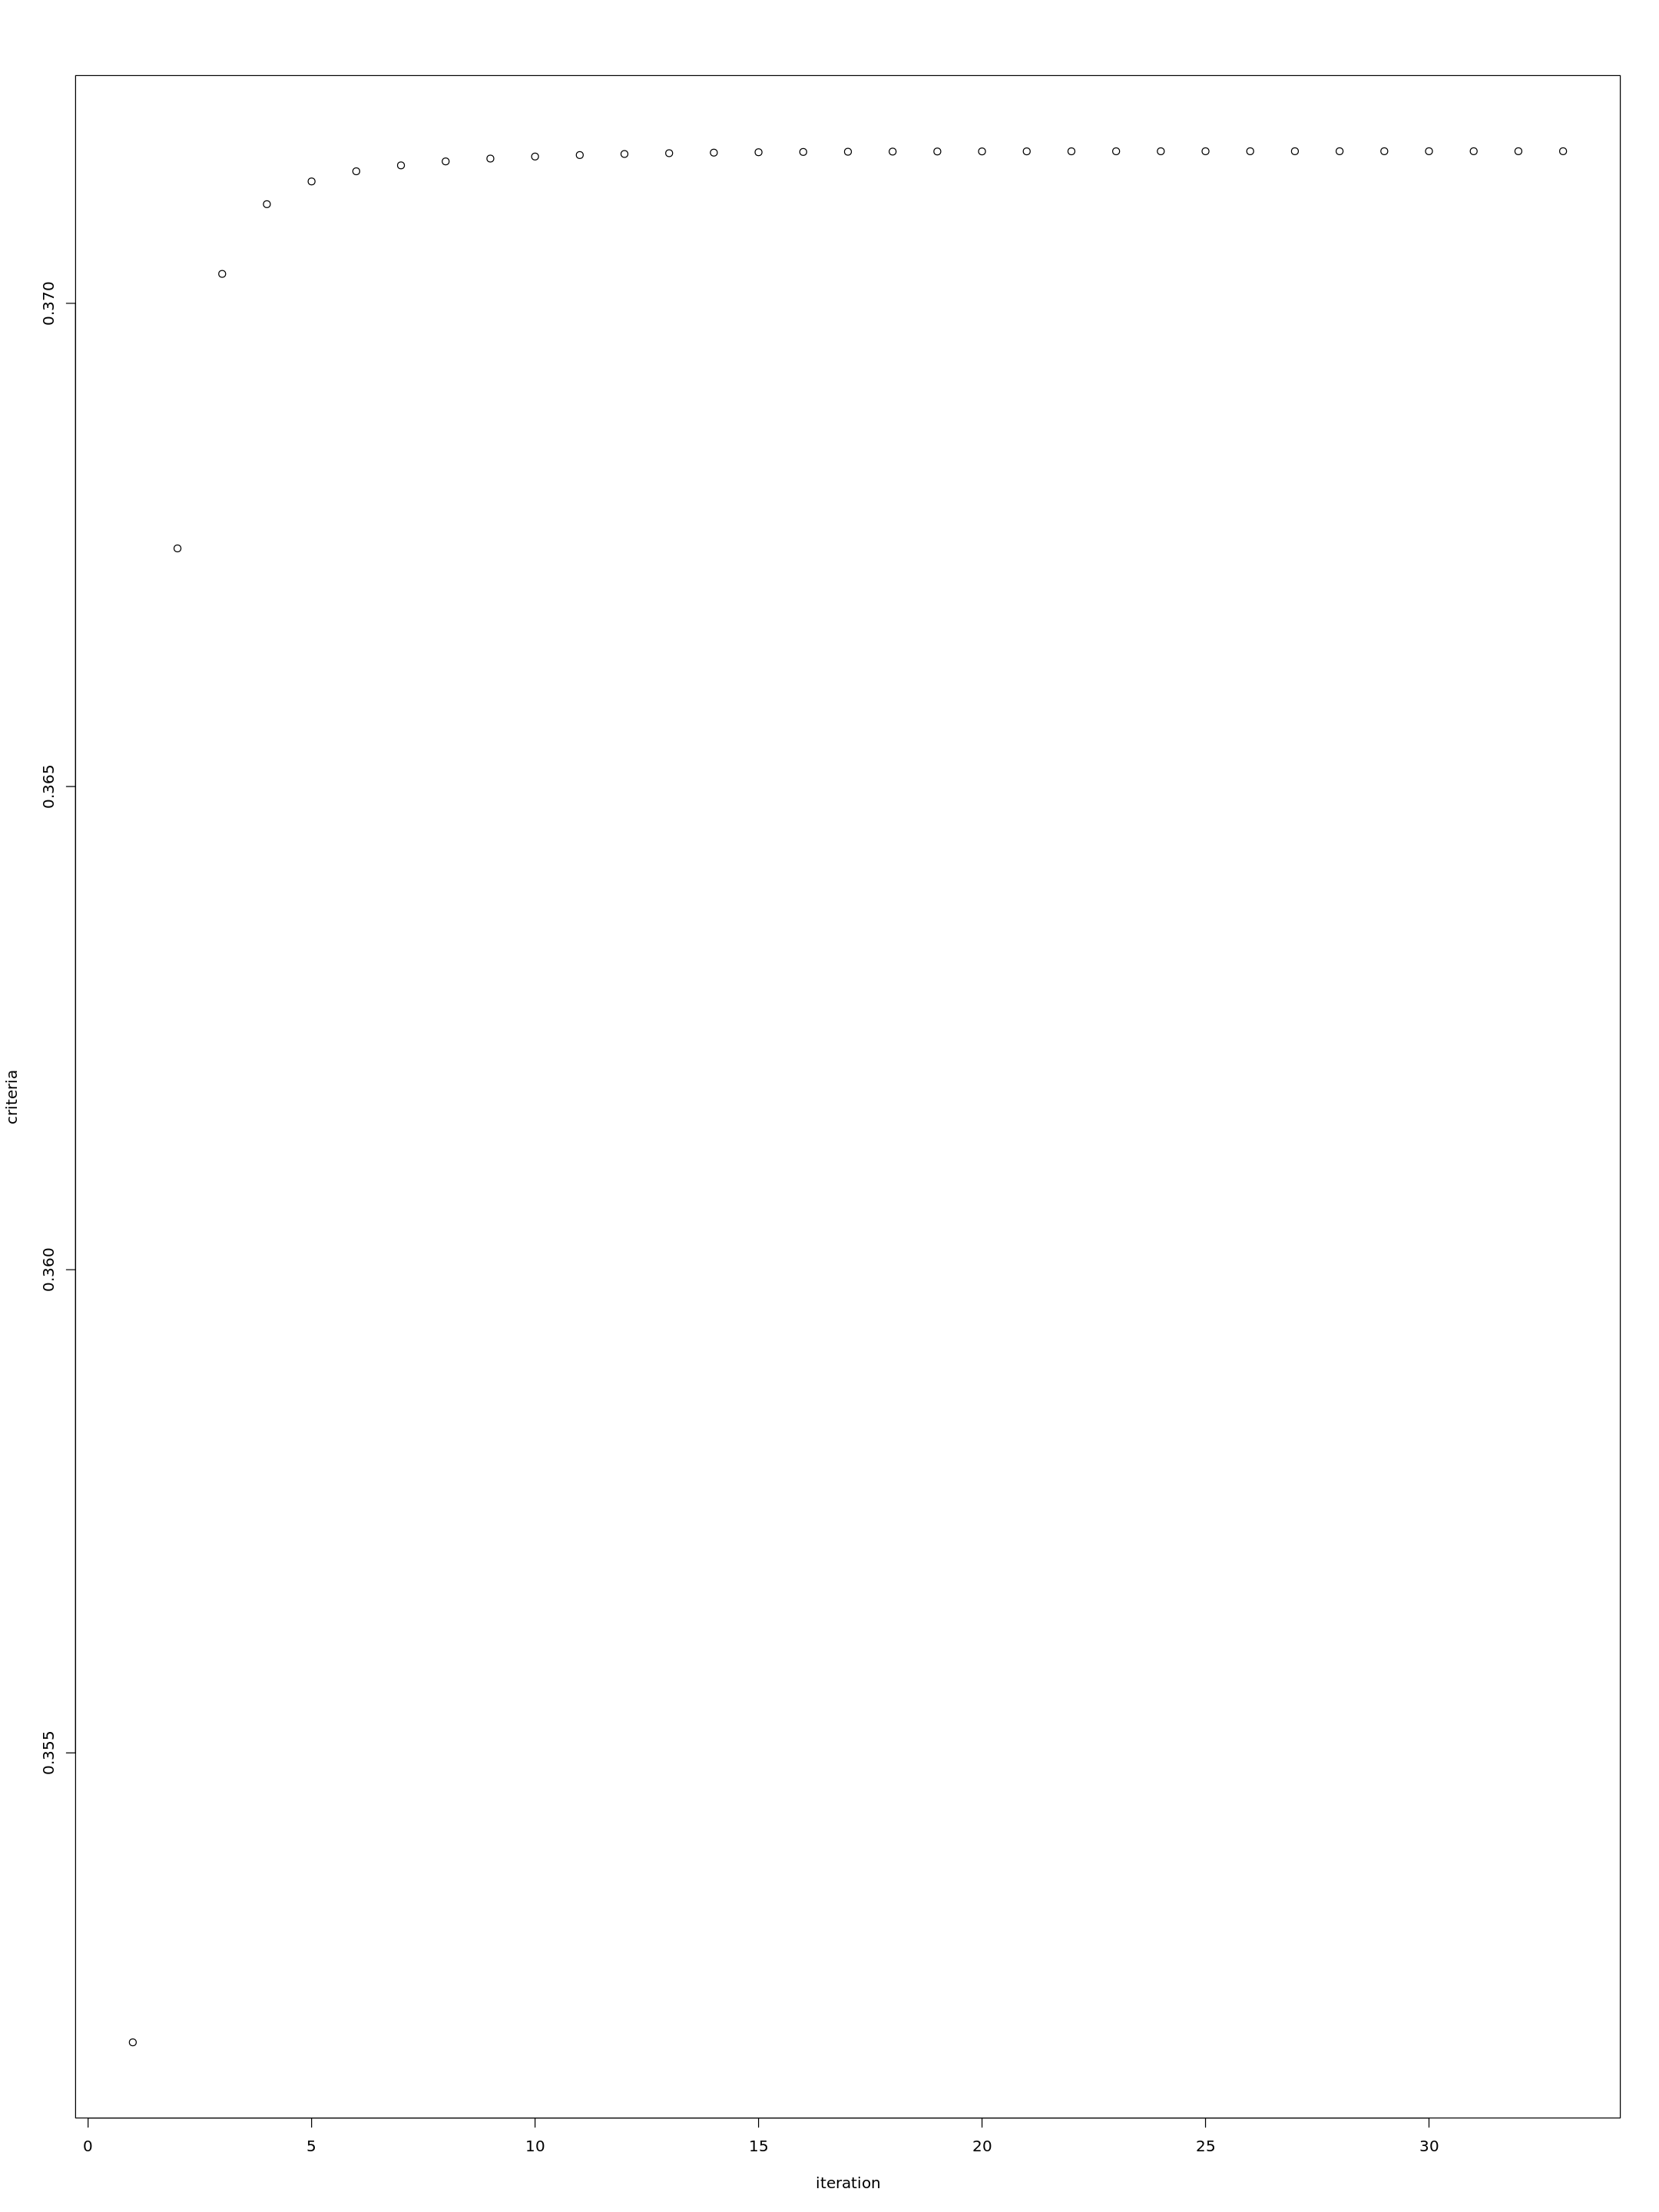

Computation of the RGCCA block components #6 is under 
                 progress...
 Iter:    1  Fit: 0.27214661  Dif:  0.11979218 
 Iter:    2  Fit: 0.28992048  Dif:  0.01777387 
 Iter:    3  Fit: 0.29568667  Dif:  0.00576619 
 Iter:    4  Fit: 0.29848640  Dif:  0.00279973 
 Iter:    5  Fit: 0.30007719  Dif:  0.00159078 
 Iter:    6  Fit: 0.30101809  Dif:  0.00094090 
 Iter:    7  Fit: 0.30157920  Dif:  0.00056111 
 Iter:    8  Fit: 0.30191442  Dif:  0.00033522 
 Iter:    9  Fit: 0.30211487  Dif:  0.00020045 
 Iter:   10  Fit: 0.30223483  Dif:  0.00011996 
 Iter:   11  Fit: 0.30230669  Dif:  0.00007186 
 Iter:   12  Fit: 0.30234976  Dif:  0.00004307 
 Iter:   13  Fit: 0.30237559  Dif:  0.00002583 
 Iter:   14  Fit: 0.30239109  Dif:  0.00001550 
 Iter:   15  Fit: 0.30240040  Dif:  0.00000930 
 Iter:   16  Fit: 0.30240599  Dif:  0.00000559 
 Iter:   17  Fit: 0.30240934  Dif:  0.00000335 
 Iter:   18  Fit: 0.30241135  Dif:  0.00000201 
 Iter:   19  Fit: 0.30241256  Dif:  0.00000121 
 Ite

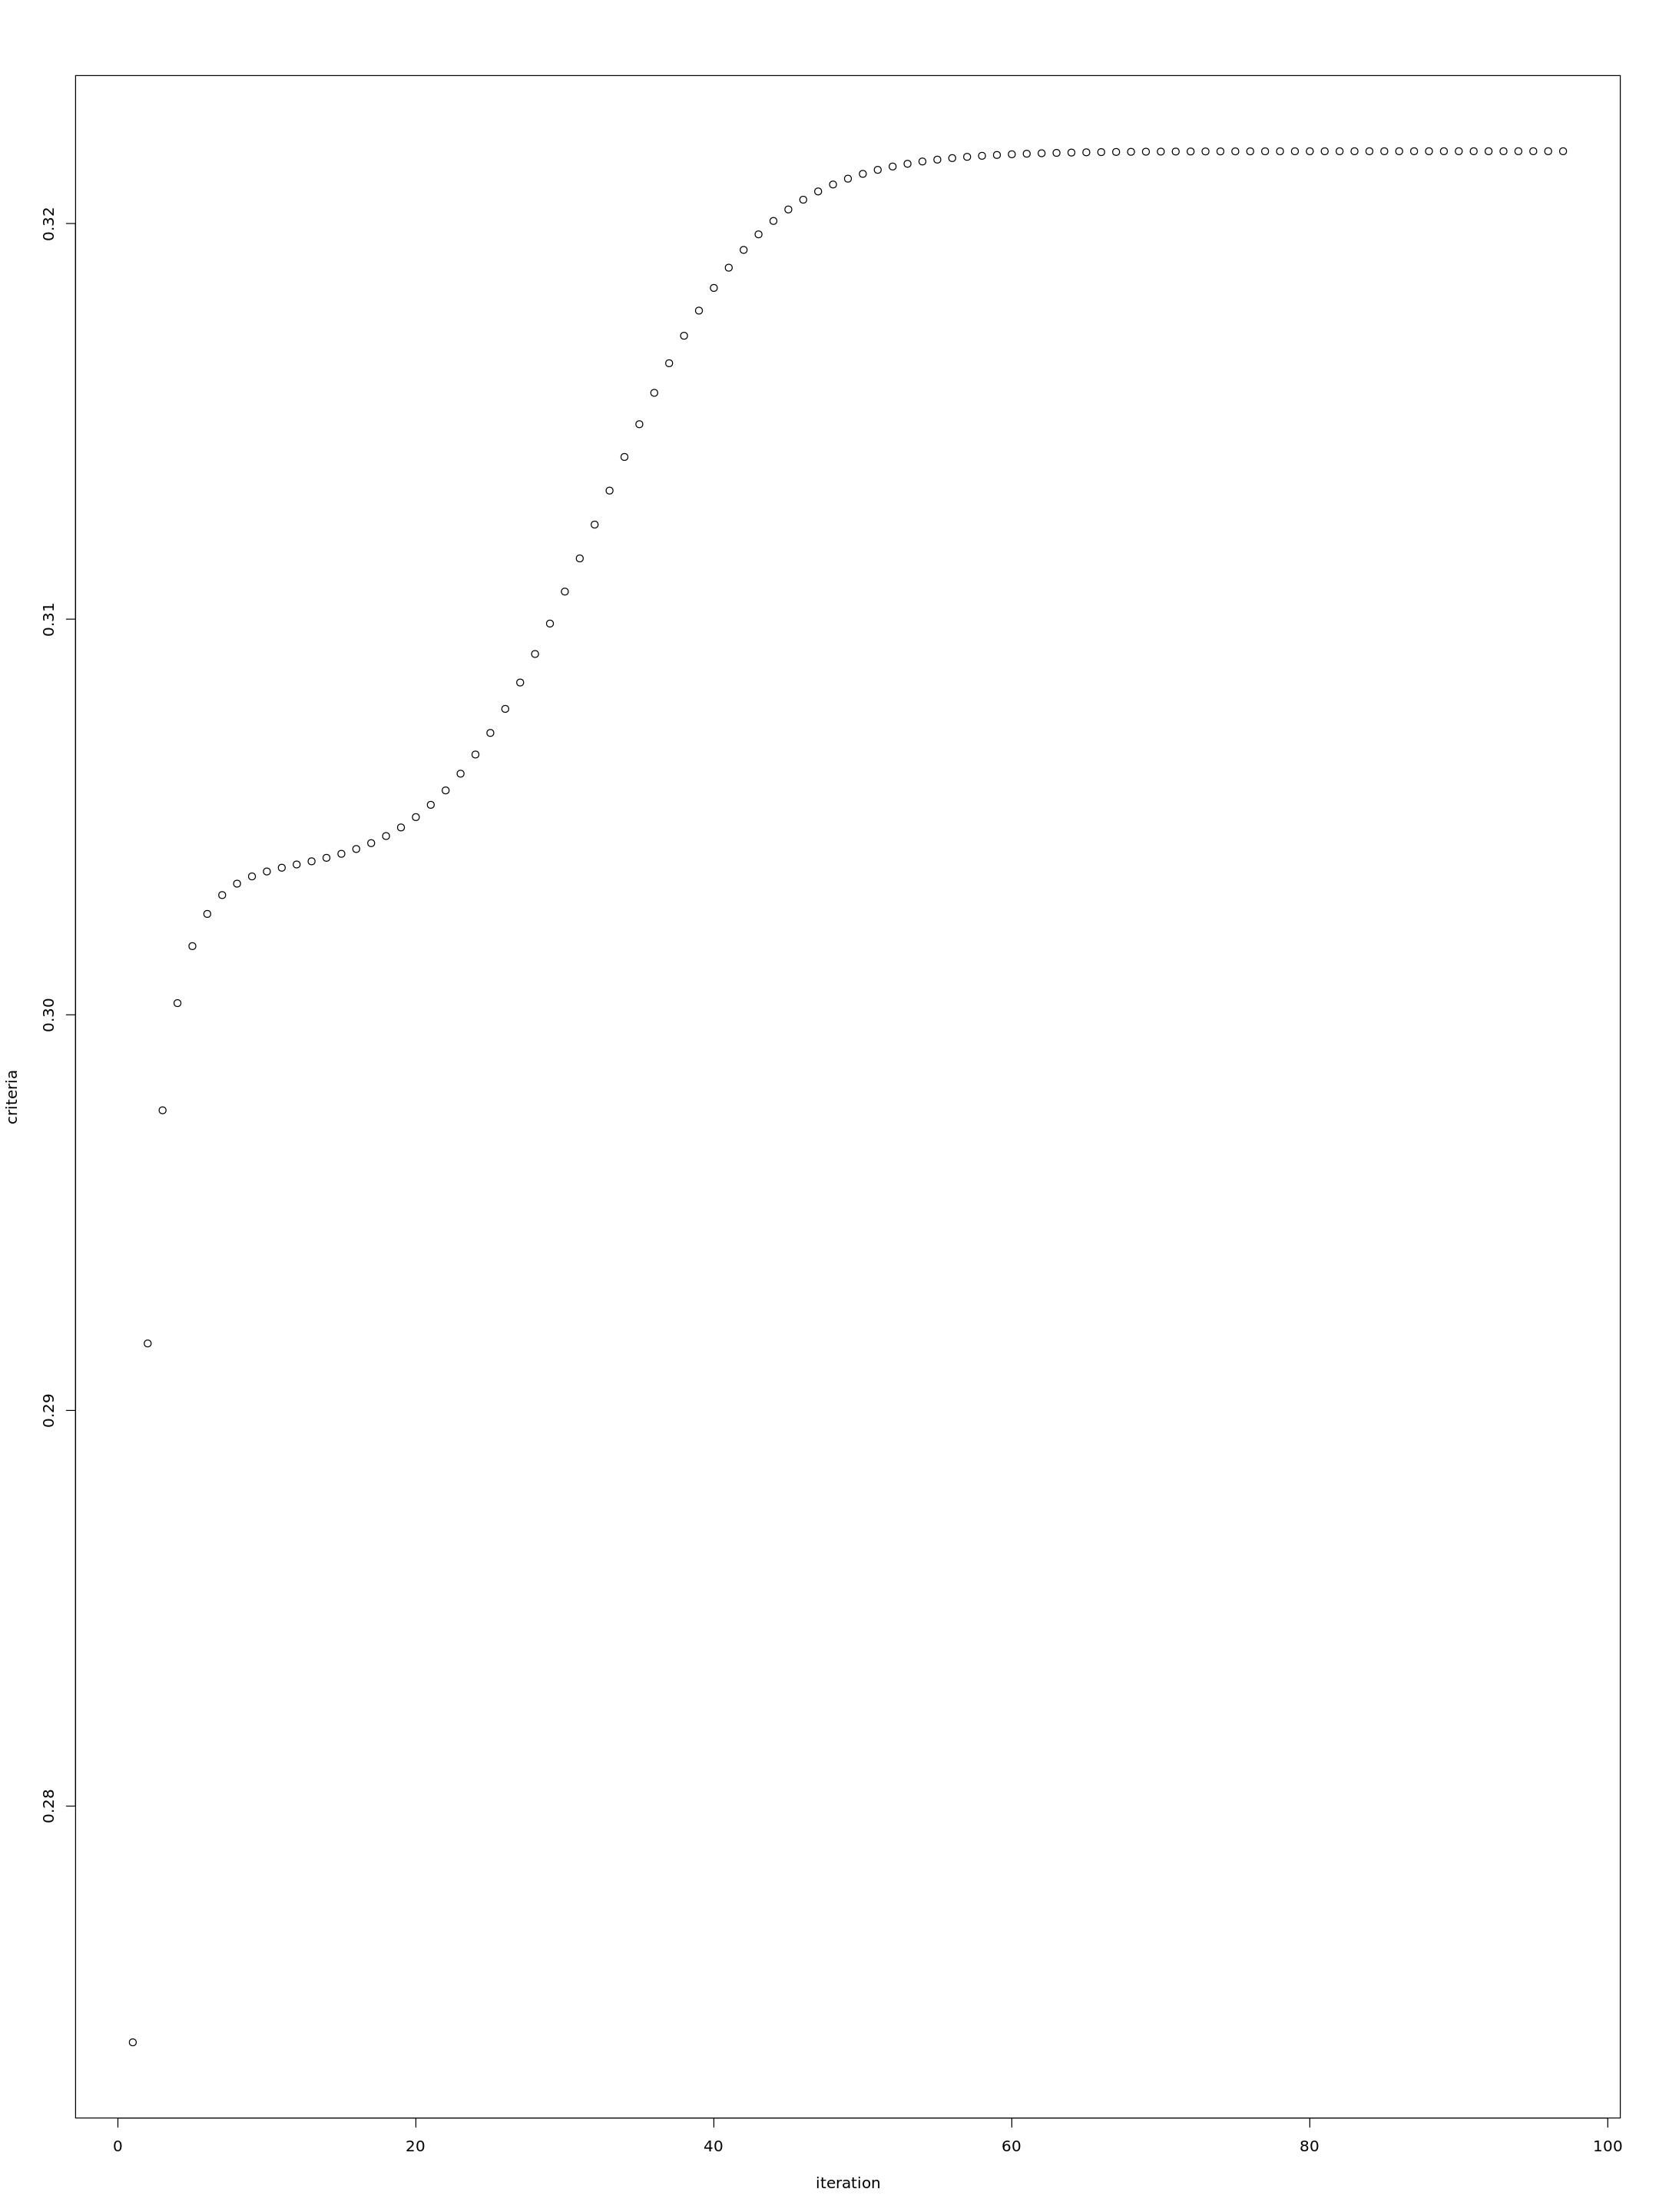

Computation of the RGCCA block components #7 is under 
                 progress...
 Iter:    1  Fit: 0.24395020  Dif:  0.15655498 
 Iter:    2  Fit: 0.25605794  Dif:  0.01210774 
 Iter:    3  Fit: 0.25949192  Dif:  0.00343398 
 Iter:    4  Fit: 0.26110558  Dif:  0.00161366 
 Iter:    5  Fit: 0.26210269  Dif:  0.00099711 
 Iter:    6  Fit: 0.26278299  Dif:  0.00068029 
 Iter:    7  Fit: 0.26325812  Dif:  0.00047513 
 Iter:    8  Fit: 0.26358973  Dif:  0.00033161 
 Iter:    9  Fit: 0.26381967  Dif:  0.00022994 
 Iter:   10  Fit: 0.26397804  Dif:  0.00015838 
 Iter:   11  Fit: 0.26408653  Dif:  0.00010849 
 Iter:   12  Fit: 0.26416053  Dif:  0.00007400 
 Iter:   13  Fit: 0.26421085  Dif:  0.00005032 
 Iter:   14  Fit: 0.26424499  Dif:  0.00003414 
 Iter:   15  Fit: 0.26426812  Dif:  0.00002313 
 Iter:   16  Fit: 0.26428377  Dif:  0.00001565 
 Iter:   17  Fit: 0.26429436  Dif:  0.00001058 
 Iter:   18  Fit: 0.26430151  Dif:  0.00000715 
 Iter:   19  Fit: 0.26430634  Dif:  0.00000483 
 Ite

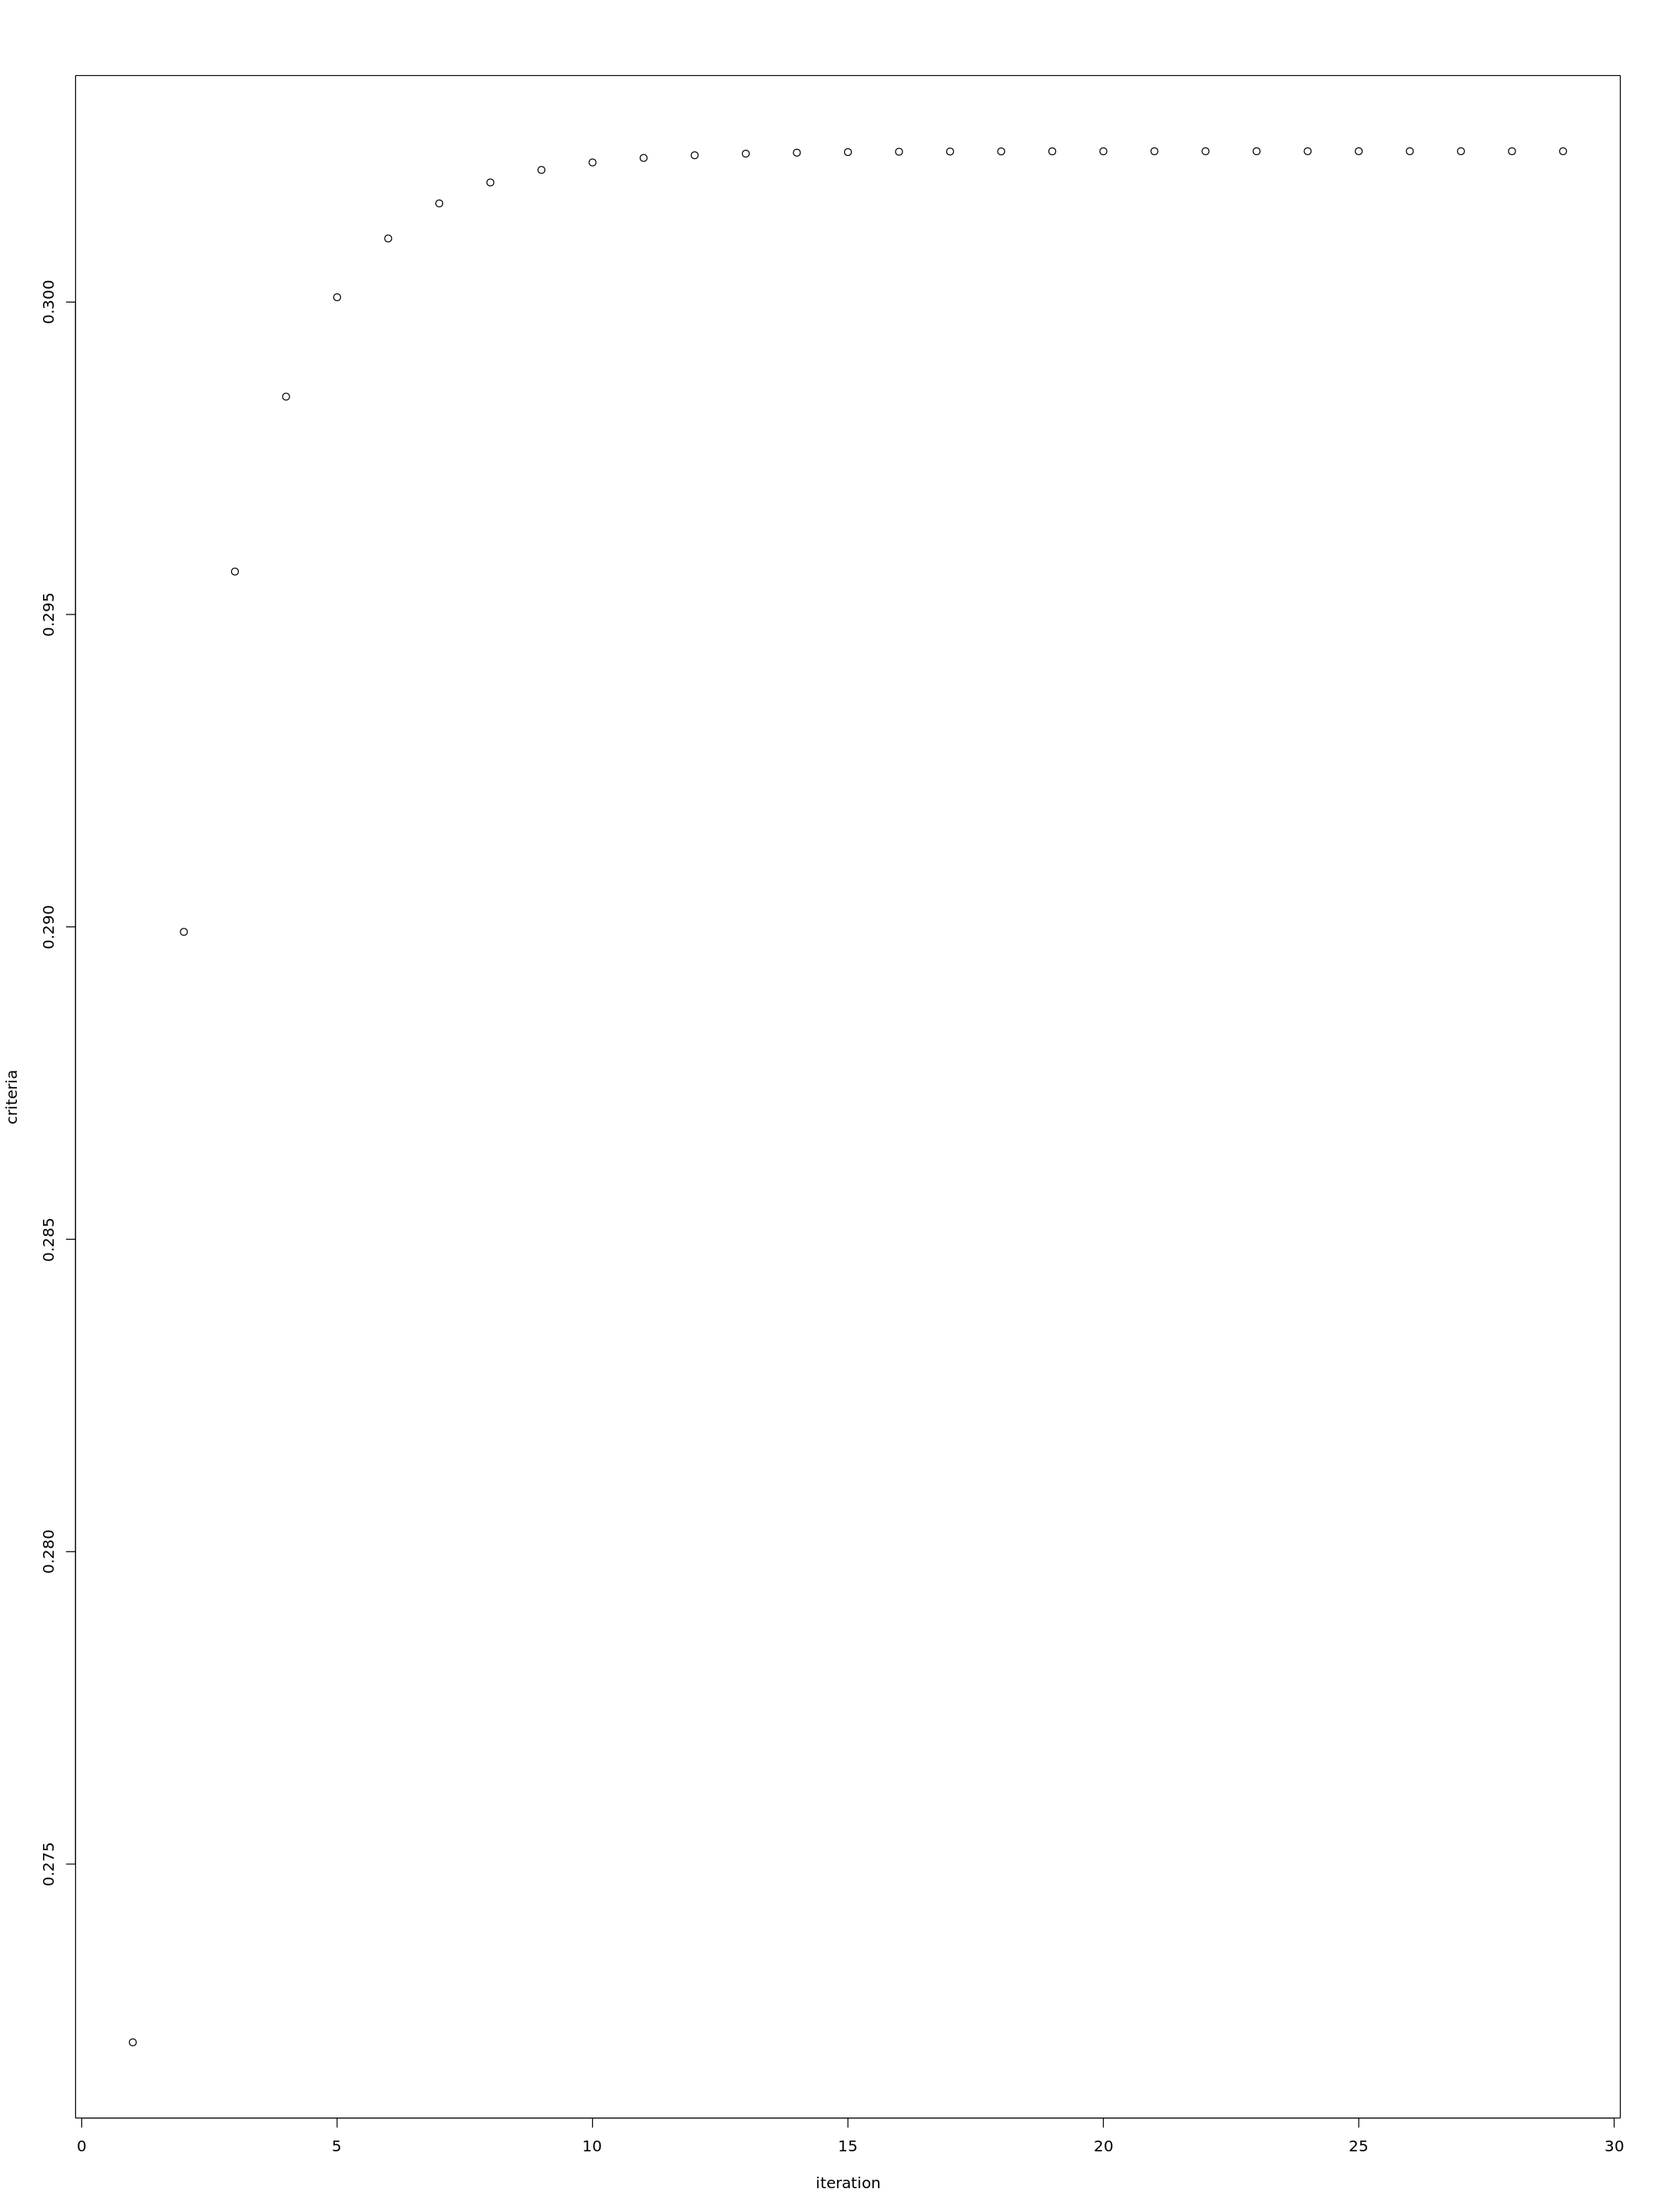

Computation of the RGCCA block components #8 is under 
                 progress...
 Iter:    1  Fit: 0.21630455  Dif:  0.19843009 
 Iter:    2  Fit: 0.23071615  Dif:  0.01441160 
 Iter:    3  Fit: 0.23591539  Dif:  0.00519924 
 Iter:    4  Fit: 0.23809873  Dif:  0.00218335 
 Iter:    5  Fit: 0.23905271  Dif:  0.00095398 
 Iter:    6  Fit: 0.23949310  Dif:  0.00044039 
 Iter:    7  Fit: 0.23971570  Dif:  0.00022260 
 Iter:    8  Fit: 0.23984342  Dif:  0.00012772 
 Iter:    9  Fit: 0.23992824  Dif:  0.00008482 
 Iter:   10  Fit: 0.23999268  Dif:  0.00006444 
 Iter:   11  Fit: 0.24004671  Dif:  0.00005404 
 Iter:   12  Fit: 0.24009482  Dif:  0.00004811 
 Iter:   13  Fit: 0.24013902  Dif:  0.00004420 
 Iter:   14  Fit: 0.24018023  Dif:  0.00004121 
 Iter:   15  Fit: 0.24021885  Dif:  0.00003862 
 Iter:   16  Fit: 0.24025506  Dif:  0.00003621 
 Iter:   17  Fit: 0.24028896  Dif:  0.00003390 
 Iter:   18  Fit: 0.24032060  Dif:  0.00003164 
 Iter:   19  Fit: 0.24035003  Dif:  0.00002943 
 Ite

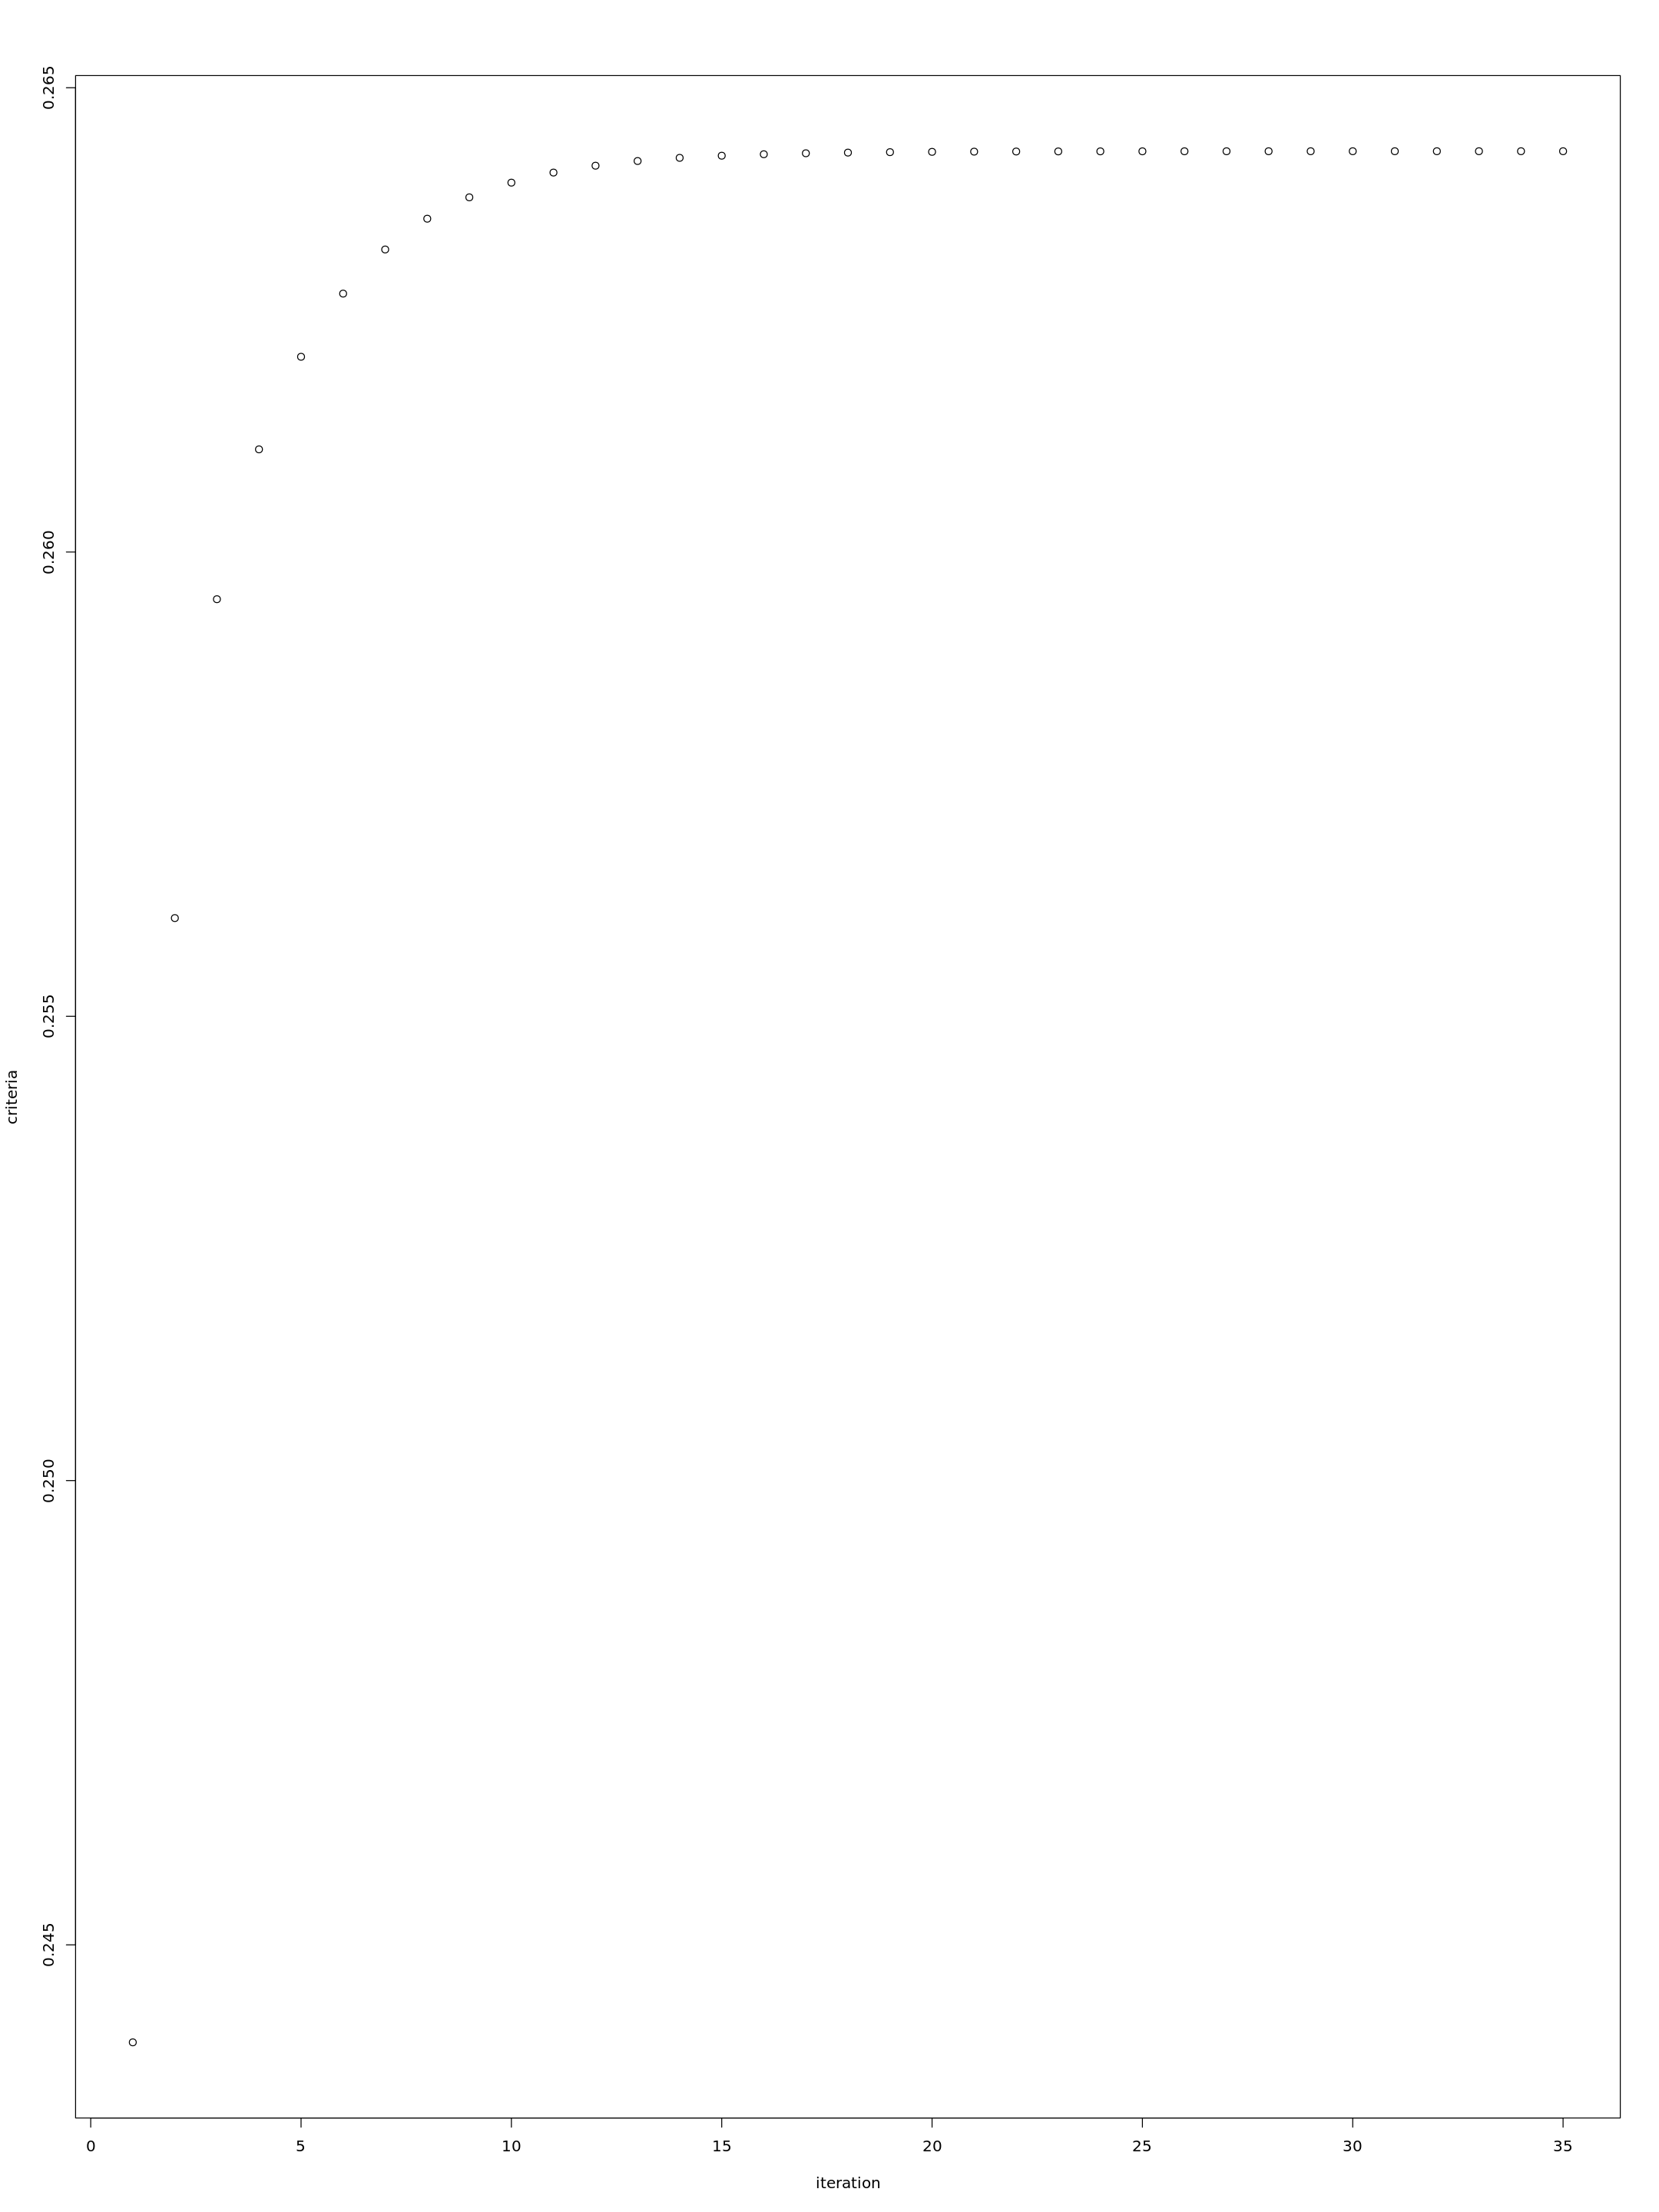

Computation of the RGCCA block components #9 is under 
                 progress...
 Iter:    1  Fit: 0.19772921  Dif:  0.13600312 
 Iter:    2  Fit: 0.21300622  Dif:  0.01527701 
 Iter:    3  Fit: 0.21990598  Dif:  0.00689976 
 Iter:    4  Fit: 0.22389554  Dif:  0.00398956 
 Iter:    5  Fit: 0.22620013  Dif:  0.00230459 
 Iter:    6  Fit: 0.22748562  Dif:  0.00128549 
 Iter:    7  Fit: 0.22818592  Dif:  0.00070030 
 Iter:    8  Fit: 0.22856370  Dif:  0.00037778 
 Iter:    9  Fit: 0.22876737  Dif:  0.00020367 
 Iter:   10  Fit: 0.22887767  Dif:  0.00011030 
 Iter:   11  Fit: 0.22893781  Dif:  0.00006014 
 Iter:   12  Fit: 0.22897086  Dif:  0.00003305 
 Iter:   13  Fit: 0.22898915  Dif:  0.00001830 
 Iter:   14  Fit: 0.22899935  Dif:  0.00001020 
 Iter:   15  Fit: 0.22900508  Dif:  0.00000572 
 Iter:   16  Fit: 0.22900831  Dif:  0.00000323 
 Iter:   17  Fit: 0.22901014  Dif:  0.00000183 
 Iter:   18  Fit: 0.22901118  Dif:  0.00000104 
 Iter:   19  Fit: 0.22901178  Dif:  0.00000060 
 Ite

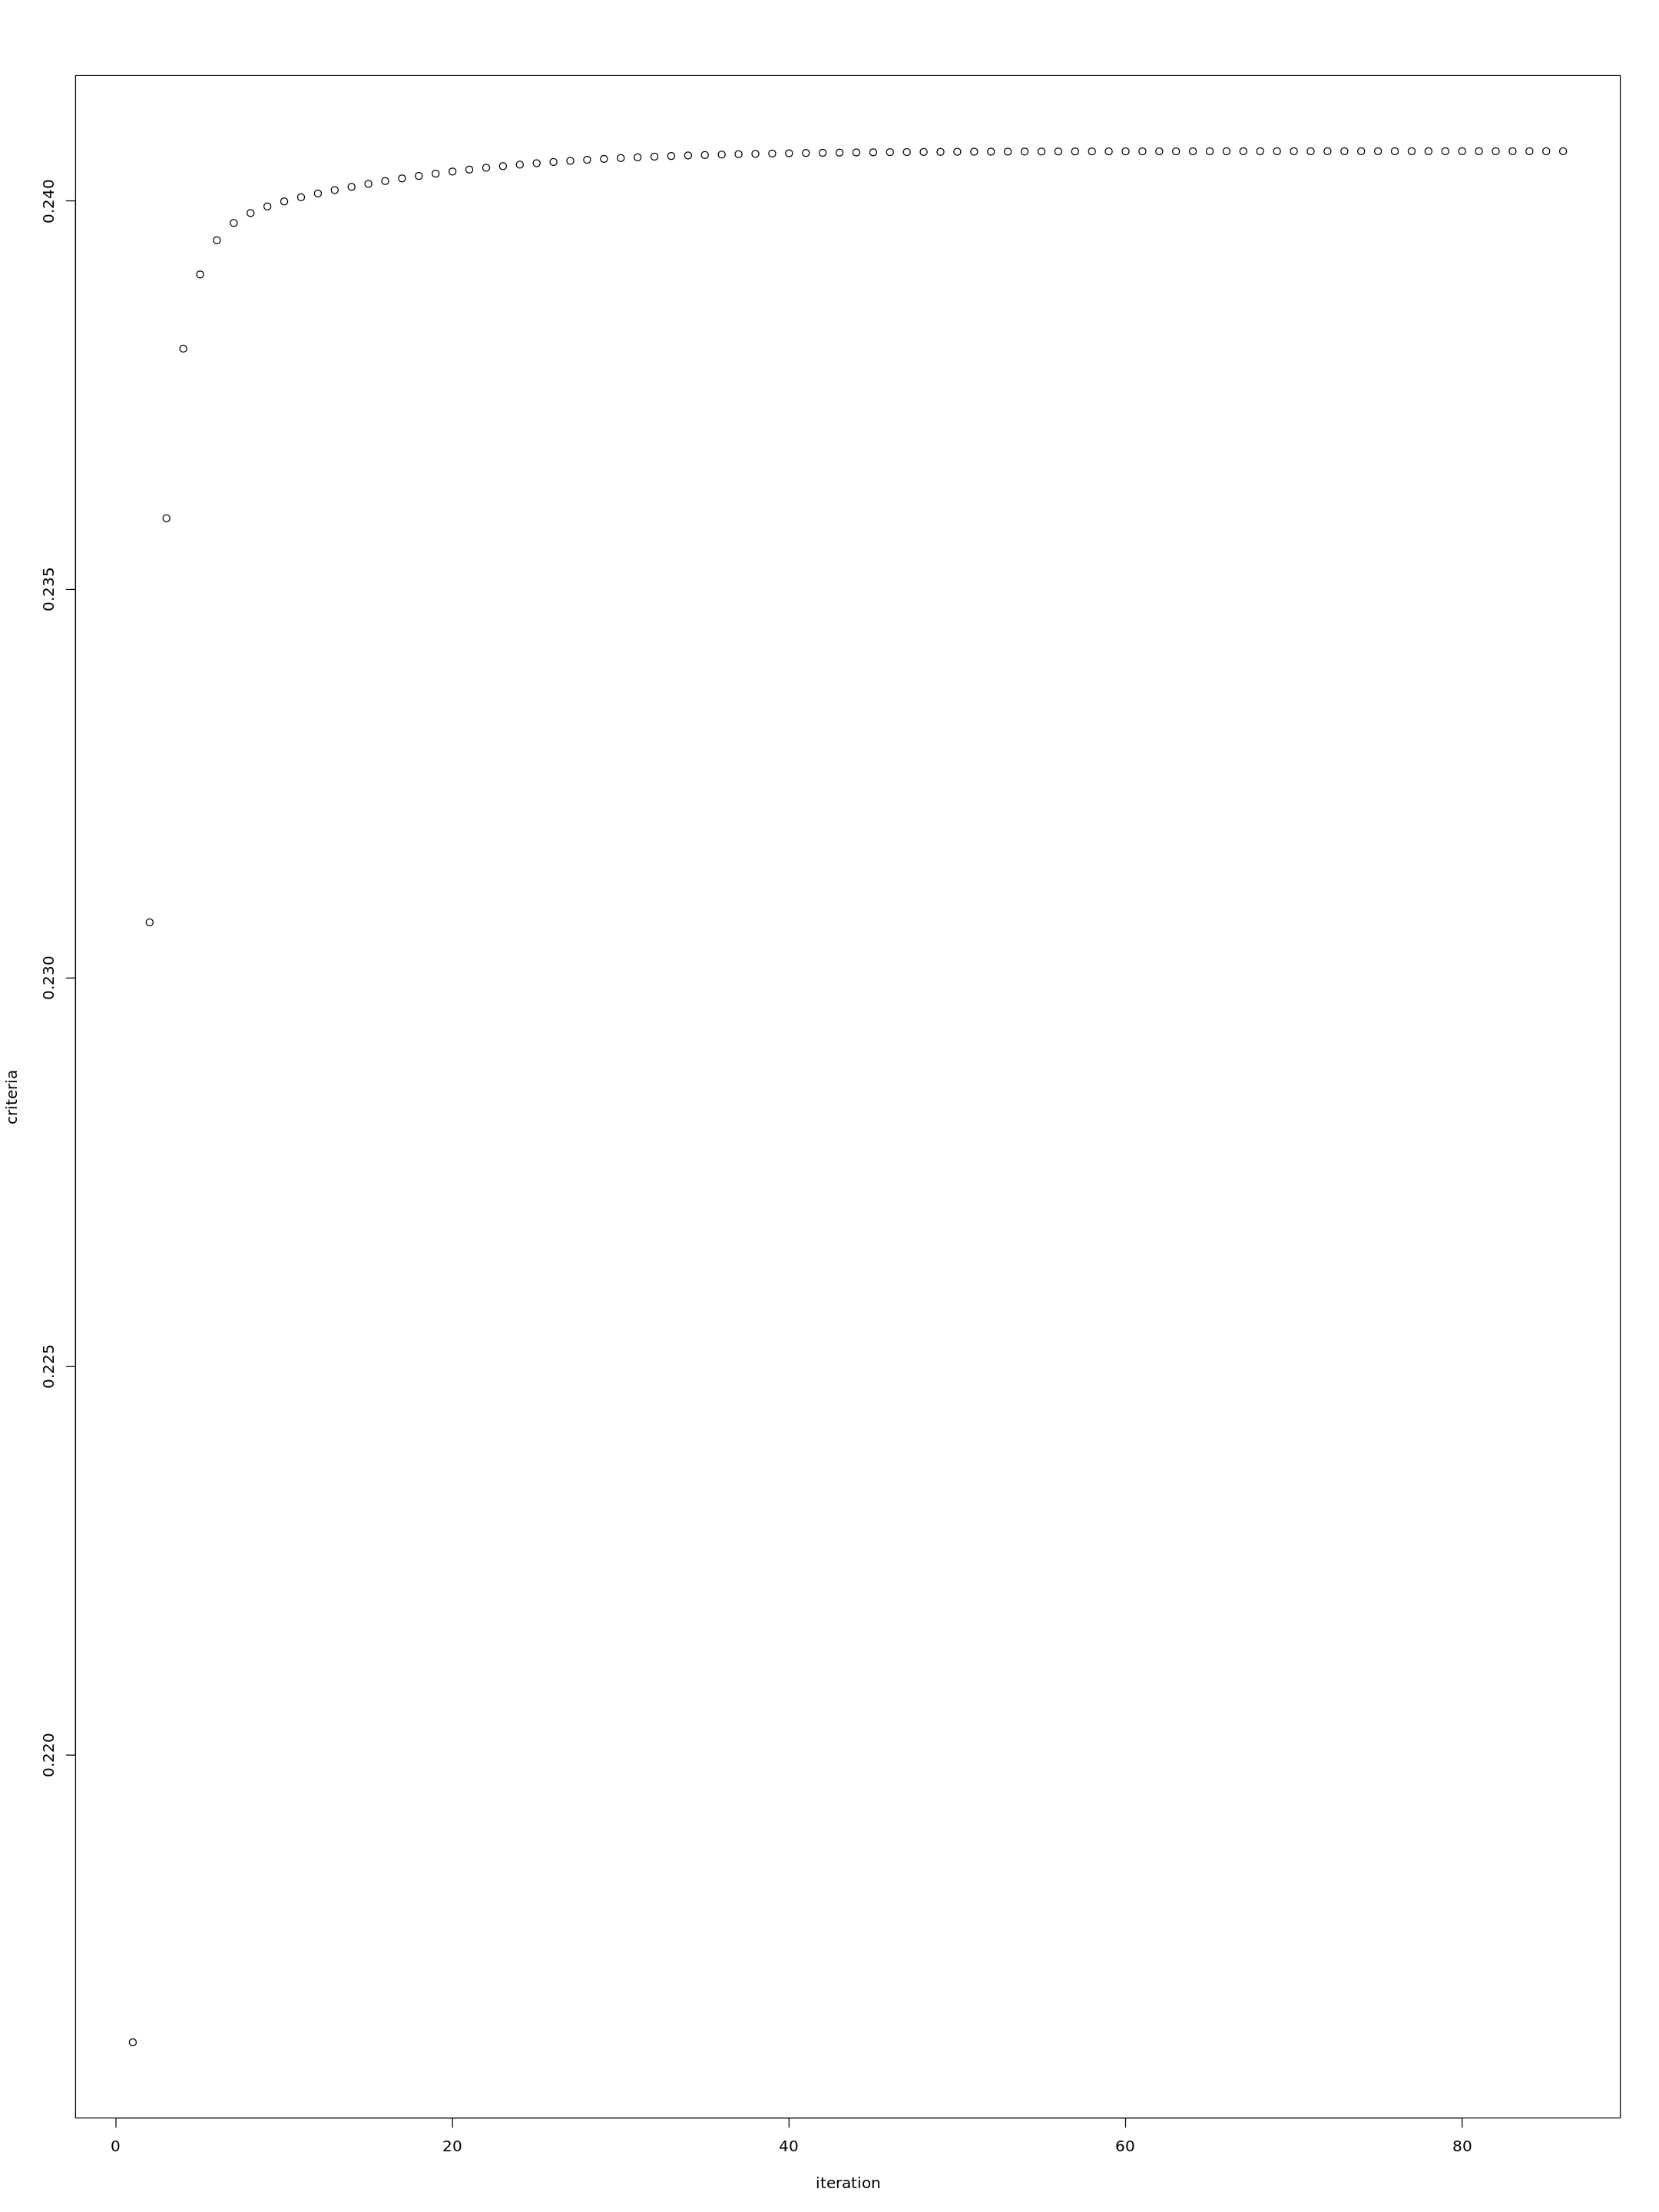

Computation of the RGCCA block components #10 is under progress ... 
 Iter:    1  Fit: 0.17740607  Dif:  0.08895176 
 Iter:    2  Fit: 0.18800079  Dif:  0.01059472 
 Iter:    3  Fit: 0.19126516  Dif:  0.00326438 
 Iter:    4  Fit: 0.19286461  Dif:  0.00159944 
 Iter:    5  Fit: 0.19387273  Dif:  0.00100812 
 Iter:    6  Fit: 0.19458047  Dif:  0.00070774 
 Iter:    7  Fit: 0.19510207  Dif:  0.00052161 
 Iter:    8  Fit: 0.19549682  Dif:  0.00039474 
 Iter:    9  Fit: 0.19580066  Dif:  0.00030385 
 Iter:   10  Fit: 0.19603730  Dif:  0.00023664 
 Iter:   11  Fit: 0.19622308  Dif:  0.00018577 
 Iter:   12  Fit: 0.19636967  Dif:  0.00014659 
 Iter:   13  Fit: 0.19648567  Dif:  0.00011600 
 Iter:   14  Fit: 0.19657756  Dif:  0.00009189 
 Iter:   15  Fit: 0.19665034  Dif:  0.00007278 
 Iter:   16  Fit: 0.19670790  Dif:  0.00005757 
 Iter:   17  Fit: 0.19675336  Dif:  0.00004545 
 Iter:   18  Fit: 0.19678916  Dif:  0.00003581 
 Iter:   19  Fit: 0.19681731  Dif:  0.00002814 
 Iter:   20  Fit: 0

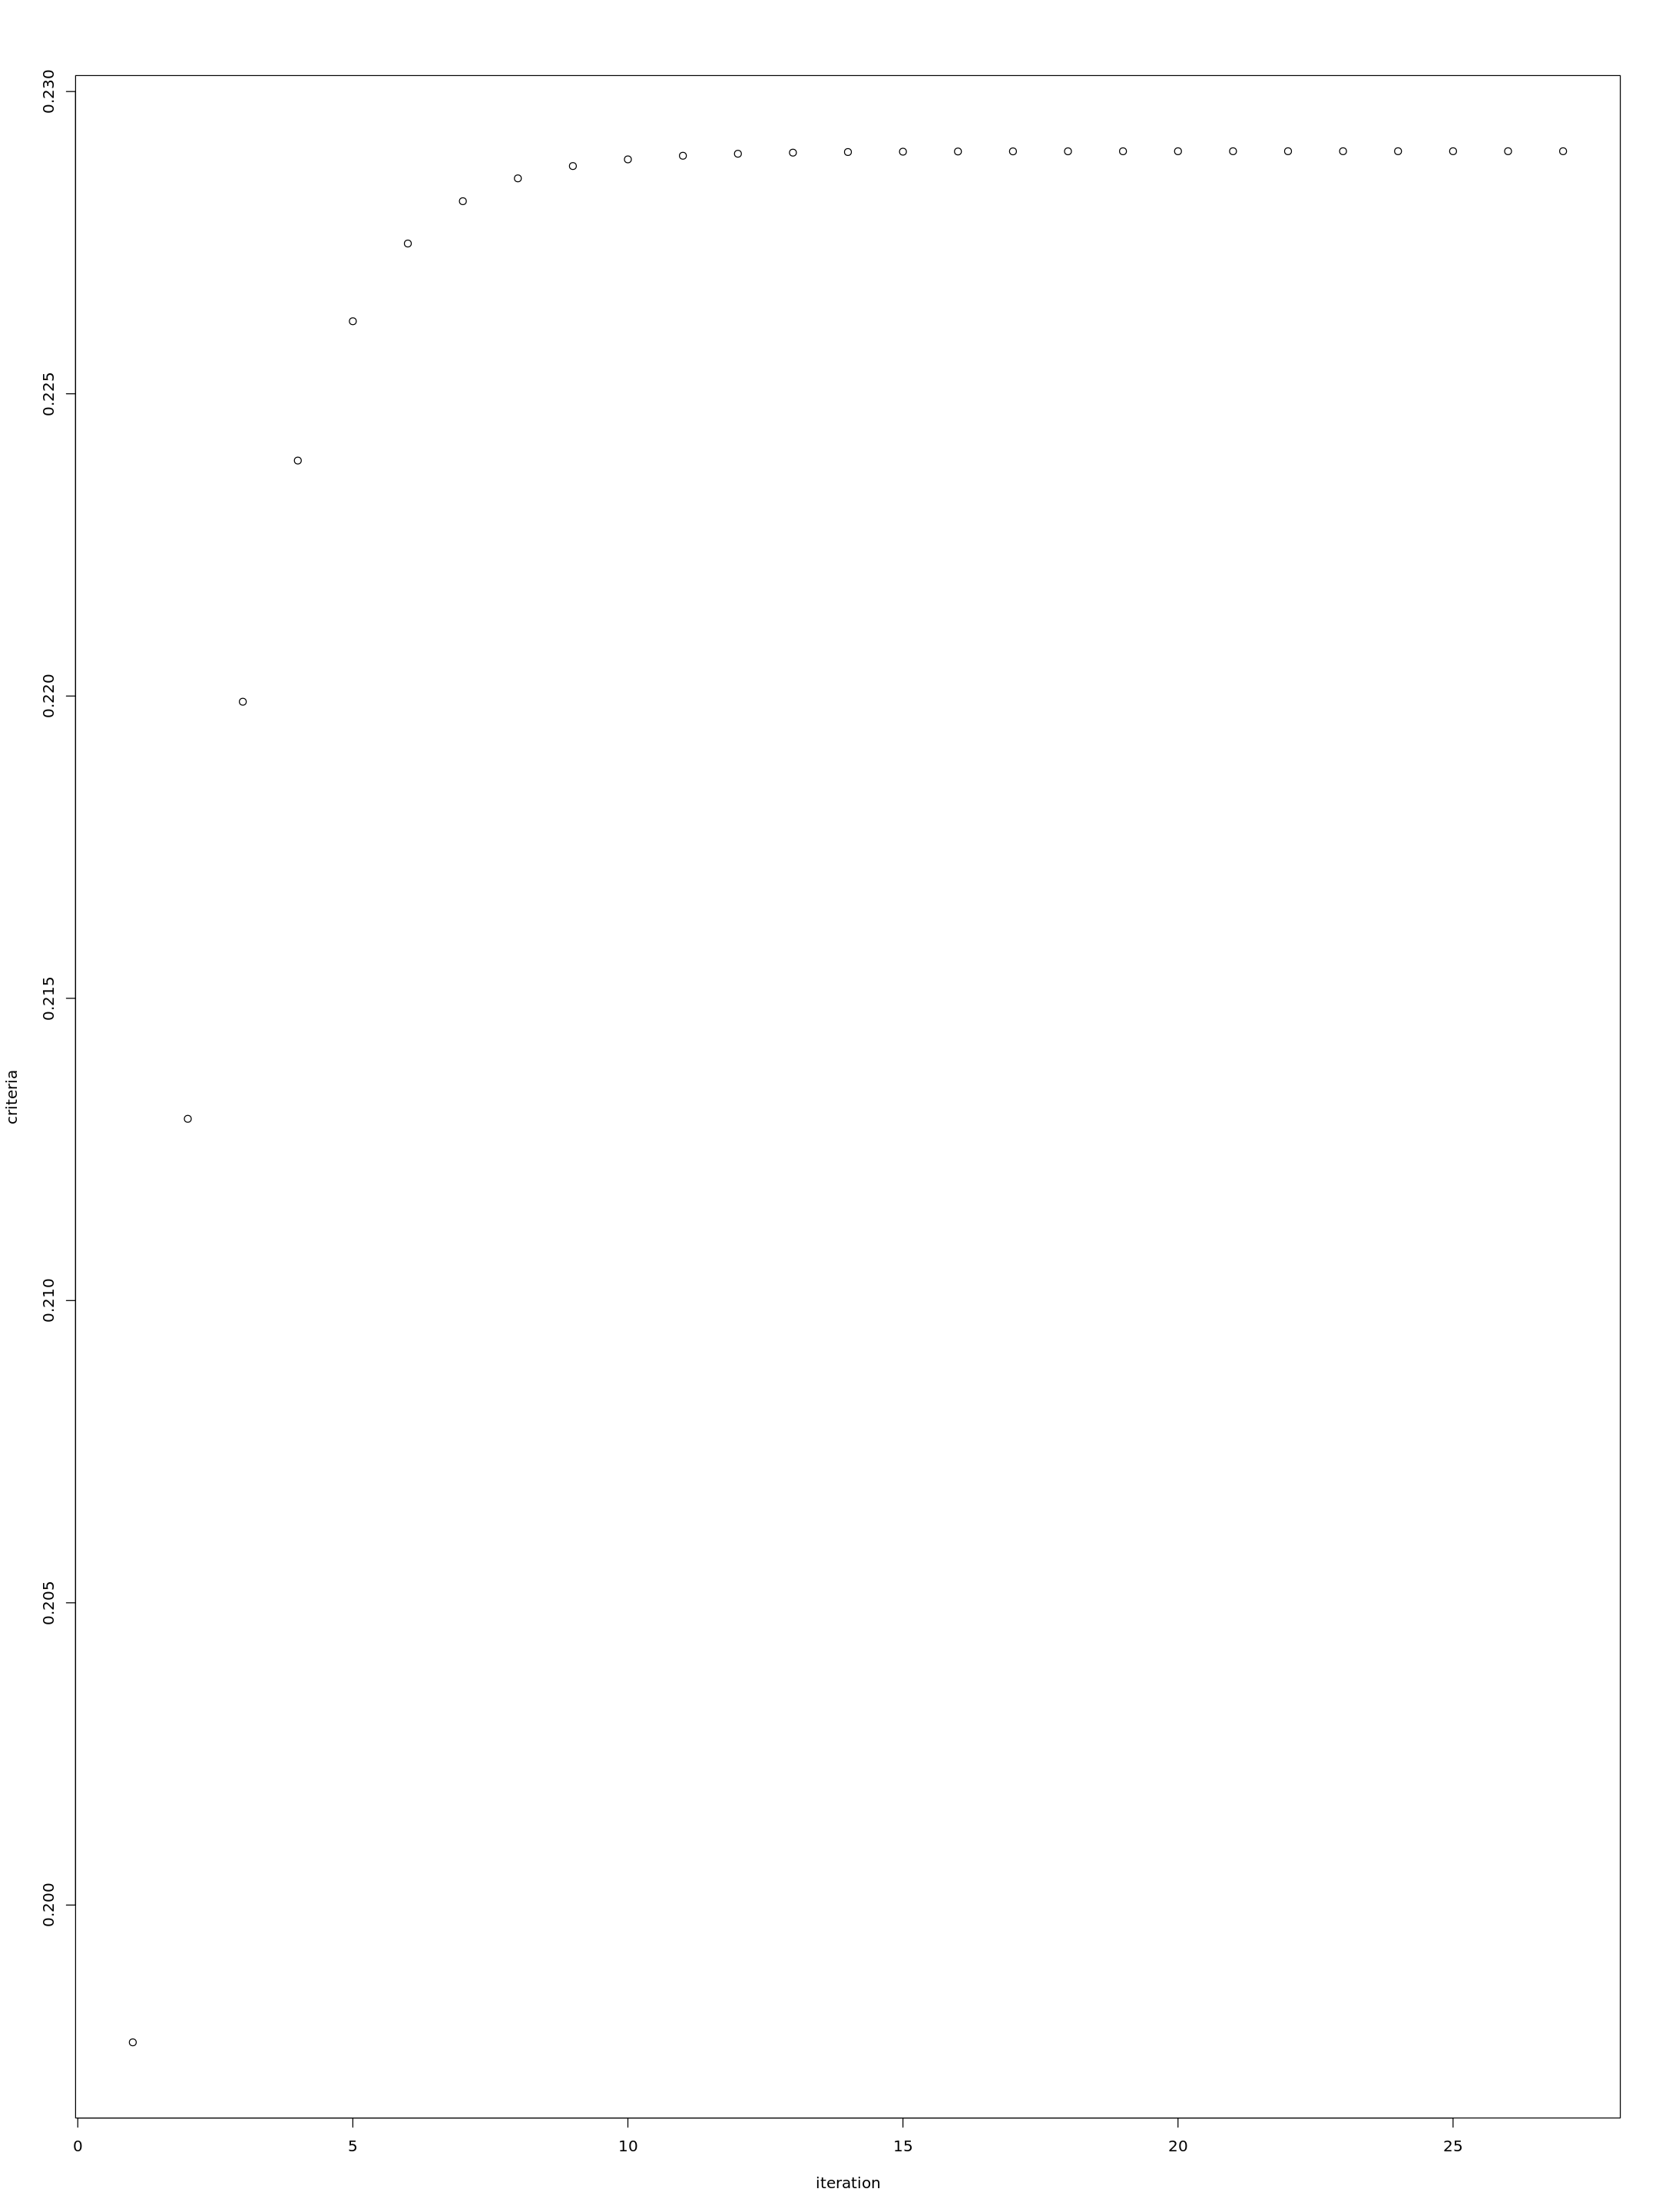

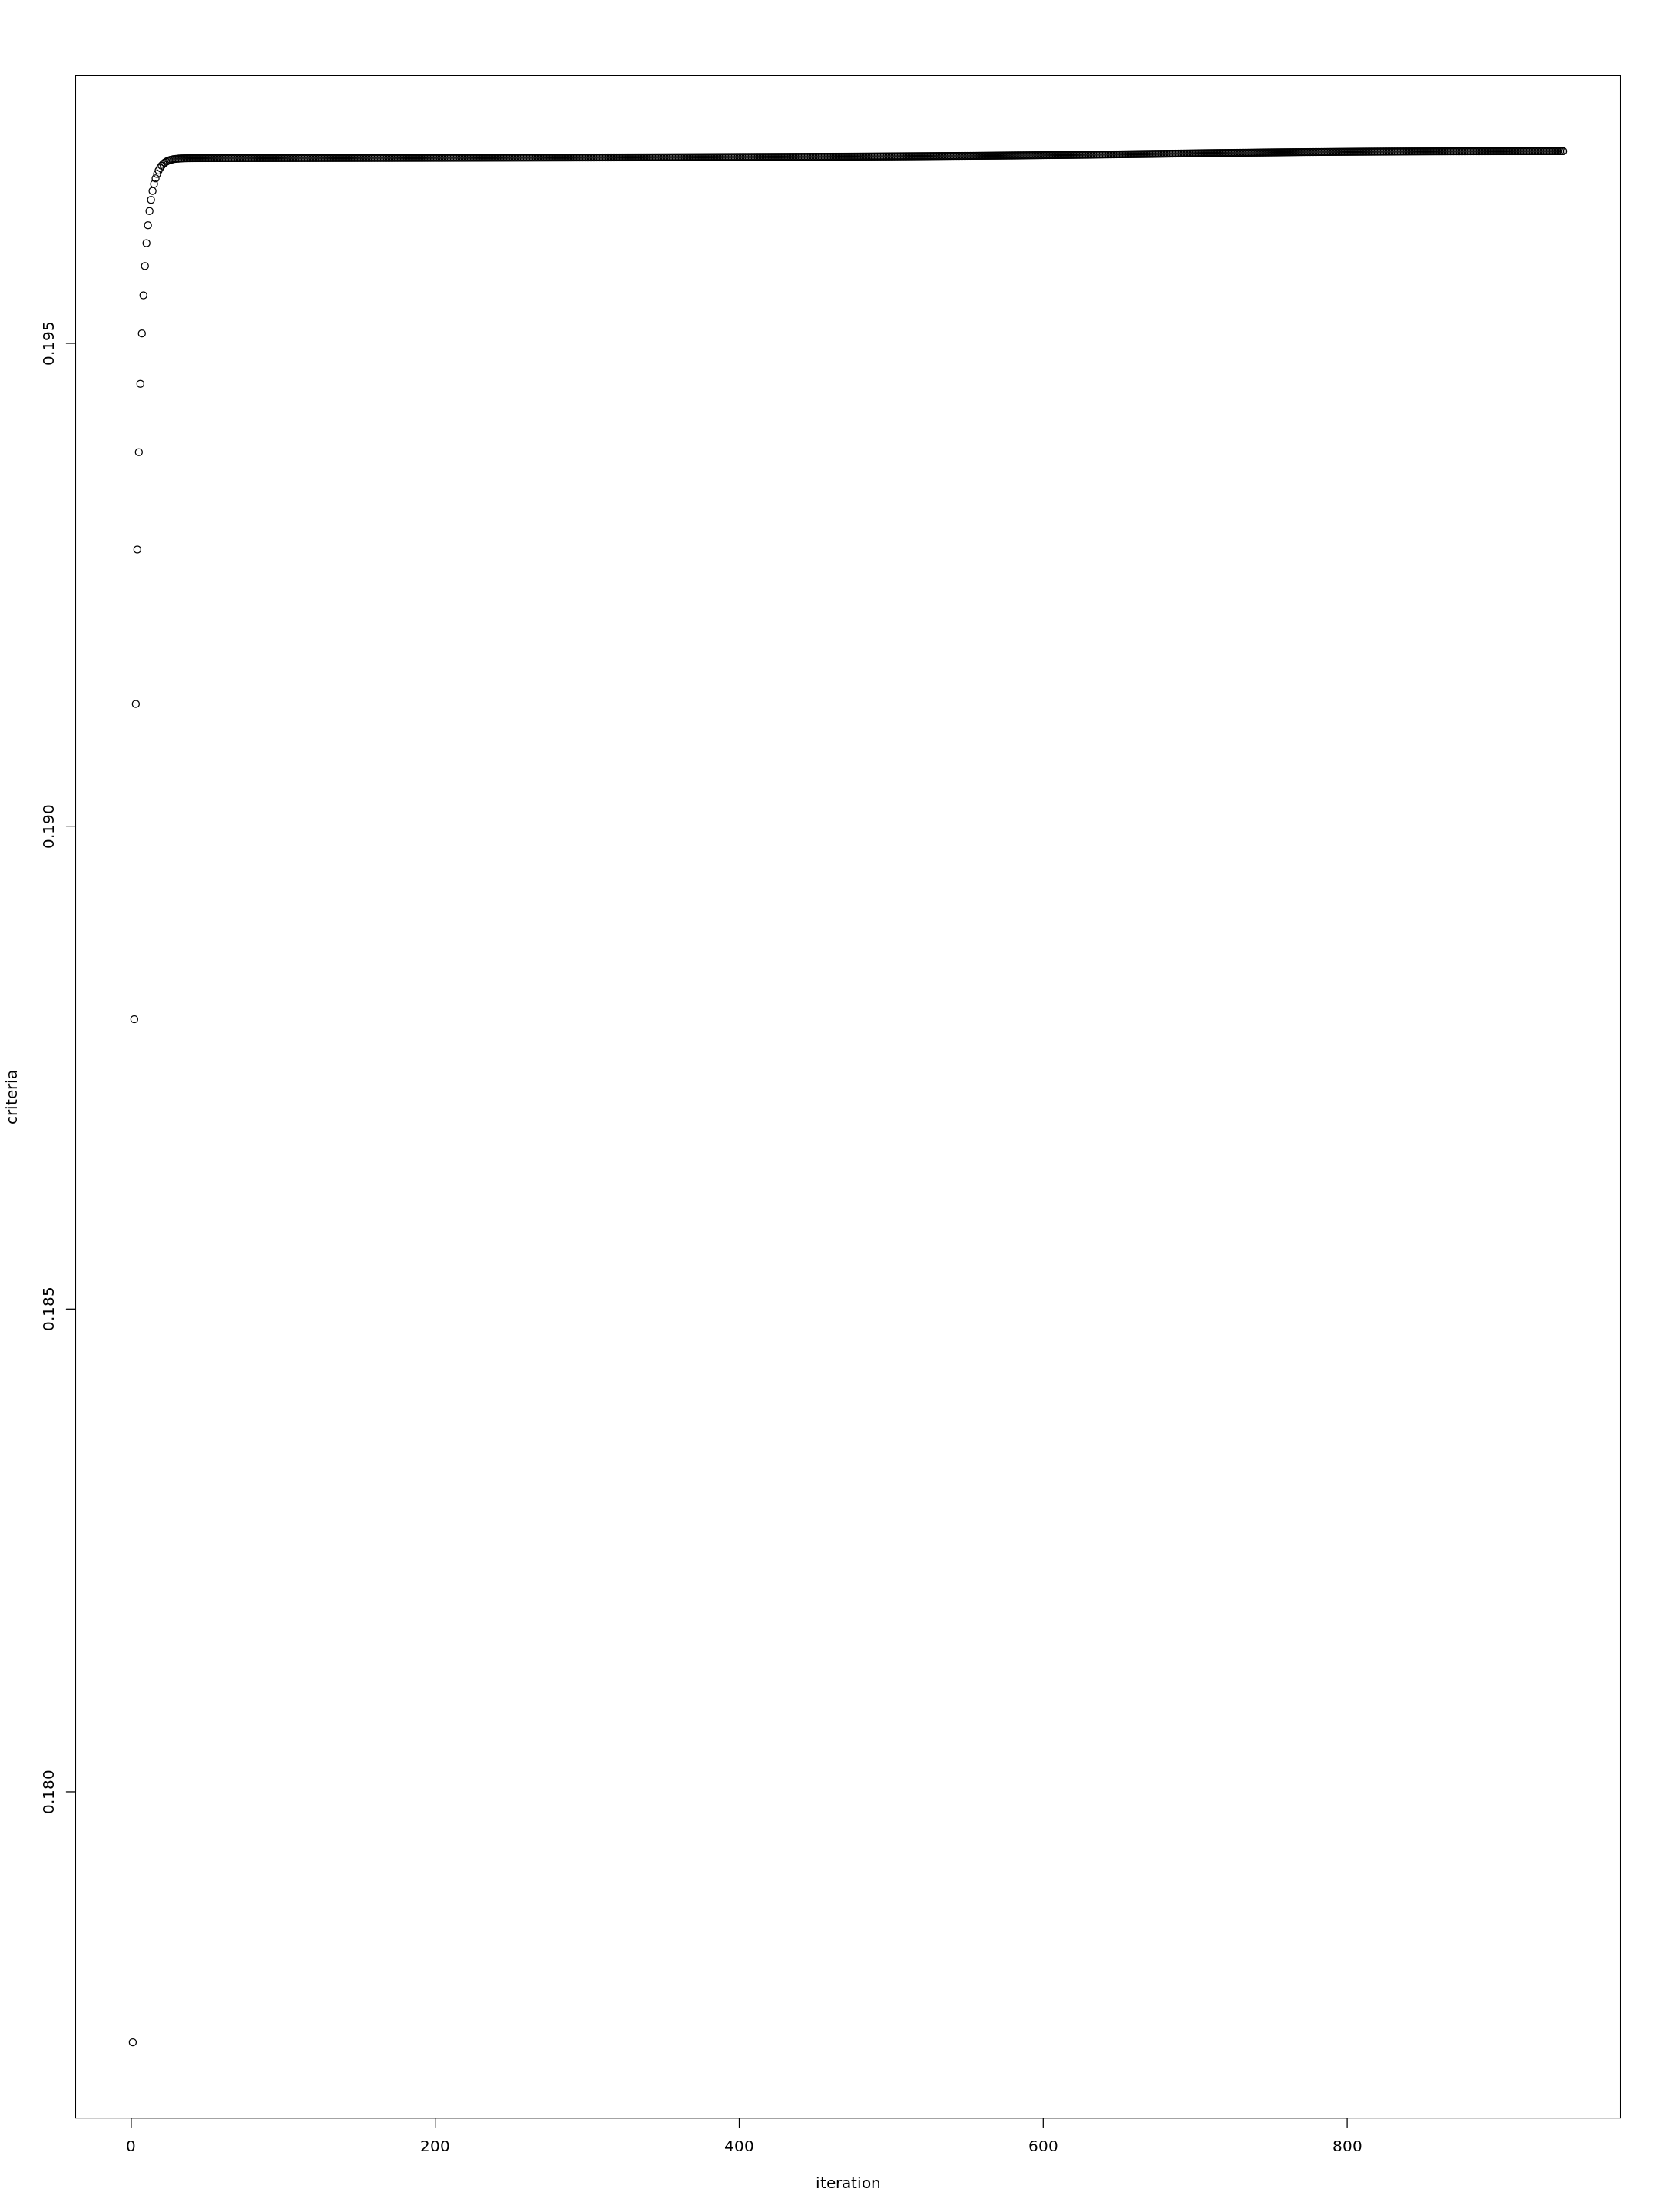

In [5]:
blocks = omics[1:3]
result.sgcca = rgcca(blocks  = blocks  , 
                     ncomp = rep(num.factors, length(blocks)), 
                     scheme = "centroid", 
                     scale = TRUE, 
                     init = "svd",
                     bias = TRUE, 
                     tol = 1e-08, 
                     verbose = T,
                     superblock = T) 

In [6]:
factors_rgcca = as.matrix(result.sgcca$Y$superblock)

In [8]:
result.sgcca$Y

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9,comp10
PCLZ117,-0.97462513,-0.009021601,0.20961233,-0.003557615,-0.073367596,0.007215358,0.113827875,0.17125008,-0.046817293,-0.1704398384
PCLZ118,0.09371470,0.145342090,0.40111830,0.125585192,-0.304240283,0.317857732,0.193362922,-0.27846513,0.053507774,0.0831290229
PCLZ119,-0.17161859,-0.008425899,0.11455106,0.214241346,0.015575872,0.245544117,0.227833125,-0.04835993,-0.075733262,0.2691005311
PCLZ121,0.16848578,-0.108610309,0.11361927,-0.540938223,0.201969073,0.046643804,-0.157509645,0.13723072,0.057827341,0.0007378436
PCLZ122,-0.27140483,-0.304720645,0.09579741,-0.037415208,0.313133497,-0.215011024,-0.117094949,-0.04710536,0.200496432,-0.1582854447
PCLZ123,0.02527587,-0.155343252,0.07626863,0.090156551,0.068719608,-0.012052715,-0.160160911,-0.02844427,-0.128172129,-0.0033350360
PCLZ124,-0.22277298,0.075149126,0.02332775,-0.565886368,-0.219386885,0.150364111,-0.091146914,-0.07001273,0.148198266,0.2179840061
PCLZ126,-0.07889223,-0.164294478,0.14205720,-0.072245672,0.021220402,0.018190246,0.067364909,-0.06879967,0.102647861,-0.0119672440
PCLZ127,-0.51265276,0.219568749,-0.28487708,0.007073436,0.378366221,0.088730916,0.099740792,0.06692438,0.020145897,-0.0294205141
PCLZ130,-0.20741101,-0.087611435,0.33935121,0.181169914,-0.084884851,-0.045590797,-0.033746073,0.01395171,0.017103973,0.0528862133


In [45]:
result.sgcca$Y

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9,comp10
PCLZ117,-0.9599513873,-0.130368922,0.023012694,0.0102324206,0.17215315,0.059951563,0.039397722,0.0666402182,0.031753220,0.112990433
PCLZ118,0.1092875249,-0.210213287,-0.105453472,-0.2501857696,0.63123872,-0.034549192,0.177419359,0.0795892429,-0.318240983,-0.085802890
PCLZ119,-0.1588563041,-0.043105384,-0.090564060,-0.0817601179,0.24308745,-0.032369813,0.057597456,-0.1268848985,-0.144405881,0.381190150
PCLZ121,0.0286460587,0.184928472,0.148360682,-0.0320075058,-0.40345576,0.154515636,0.308145838,-0.1364384910,-0.003621292,-0.126852931
PCLZ122,-0.2686060085,0.366929101,0.266477577,-0.2052858042,-0.23442803,-0.060283207,-0.173949595,-0.1012072740,0.019611714,-0.059583376
PCLZ123,-0.0003594316,0.072650409,-0.015203243,-0.0189807357,0.07652251,-0.052819863,-0.094386247,-0.1362126178,0.220828527,-0.160061858
PCLZ124,-0.3288746446,-0.148499161,0.173114684,0.0309787035,-0.13672855,0.164714348,0.281733963,0.0651858787,-0.185475151,-0.154102392
PCLZ126,-0.1146271568,0.190387023,0.081104654,-0.1353768948,0.03179551,0.008559887,0.033820375,0.0059986650,-0.070779334,0.007914291
PCLZ127,-0.3946391253,-0.132117576,-0.118400022,-0.0006516314,-0.41067639,-0.157200305,0.086078630,-0.1190258099,0.022082225,0.167626286
PCLZ130,-0.1992134219,0.002200732,-0.027845301,-0.1176603904,0.32635686,0.026693356,-0.025499161,-0.0341384378,0.141268248,-0.007497251


In [10]:
factors_rgcca

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9,comp10
PCLZ117,-0.211770640,-0.73907375,-0.523374855,0.101450806,0.13138831,0.222934191,0.304850311,-0.42158054,-0.284143121,-0.262884910
PCLZ118,-0.089559272,0.28091731,-0.286615796,-0.269985969,0.35390550,0.806275043,0.318746020,0.69096679,0.072792654,0.121355882
PCLZ119,-0.062359227,-0.28356039,-0.001966662,-0.146598827,0.05485243,0.622322055,0.332760209,0.13494239,-0.142289605,0.377896866
PCLZ121,1.086163250,-0.54453870,-0.478230194,-0.769266382,-0.08772232,-0.089685185,-0.376388999,-0.21506061,0.231179535,0.042941883
PCLZ122,0.263960238,-0.67800518,-0.266192821,-0.181965529,-0.54783269,-0.118642716,-0.190645452,-0.13158148,0.298165541,-0.205991331
PCLZ123,0.155425442,-0.17256026,-0.301991232,0.384000031,0.07168806,0.070682999,-0.383844690,0.11498369,-0.338955416,-0.027556433
PCLZ124,-0.152208746,-0.54165048,-0.101653316,-0.873403896,0.26944988,0.041201023,-0.042644246,0.02387133,0.250221196,0.107397095
PCLZ126,0.308238671,-0.36317040,-0.153326103,-0.144745855,0.12488911,0.220259096,0.116387745,0.01427439,0.075540986,0.031755737
PCLZ127,-0.805594180,0.07428156,0.076368943,-0.255639966,-0.49226062,0.111069988,0.238431052,-0.44325466,0.100947524,-0.187269478
PCLZ130,-0.305204072,-0.36984880,-0.507770860,0.287187179,0.30740613,0.068050265,-0.034846013,0.27514720,0.048486391,0.167132924


In [11]:
metagenes_rgcca <- list()
  for(j in 1:length(blocks)){
    metagenes_rgcca[[j]]<-as.matrix(result.sgcca$a[[j]])
    rownames(metagenes_rgcca[[j]])<-rownames(t(blocks[[j]]))
    colnames(metagenes_rgcca[[j]])<- paste("RGCCA_" ,1:num.factors)
  }

In [12]:
factorizations_rgcca = list ( factors_rgcca = factors_rgcca ,
                   features_RGCCA =  metagenes_rgcca)

In [13]:
saveRDS(factorizations_rgcca , file = "factorizations_rgcca.RDS")

In [14]:
saveRDS(result.sgcca , "result.sgcca.RDS")